In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch.optim
from torchvision.datasets import MNIST
import torch.nn as nn
import os
from sklearn.manifold import TSNE
from torch.nn import CrossEntropyLoss, Flatten
from torch.nn.functional import relu

Loading data below

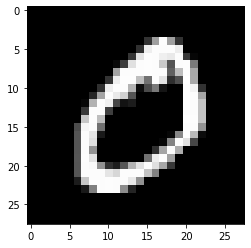

In [2]:
path = os.getcwd()

# train data
data = MNIST(path, train=True, download=True)
plt.imshow(np.array(data.__getitem__(1)[0].getdata()).reshape([28,28]), cmap='gray')
required_indices = []
for i in range(10):
    counter = 0
    inds = []
    j = 0
    while j < 100:
        if data.__getitem__(counter)[1] == i:
            inds.append(counter)
            j += 1
        counter += 1
    required_indices.append(inds)
dat = torch.zeros([1000, 1, 28, 28])
labs = []
for i in range(10):
    for j in range(100):
        labs.append(i)
        dat[100*i+j, :, :, :] = torch.Tensor(np.array(data.__getitem__(required_indices[i][j])[0].getdata()).reshape([28,28])/255)
labs = torch.Tensor(labs).type(torch.LongTensor)

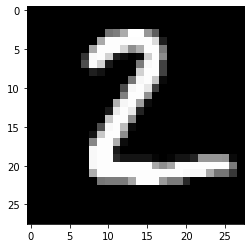

In [3]:
# test data
data = MNIST(path, train=False, download=True)
plt.imshow(np.array(data.__getitem__(1)[0].getdata()).reshape([28,28]), cmap='gray')
required_indices = []
for i in range(10):
    counter = 0
    inds = []
    j = 0
    while j < 10:
        if data.__getitem__(counter)[1] == i:
            inds.append(counter)
            j += 1
        counter += 1
    required_indices.append(inds)
test = torch.zeros([100, 1, 28, 28])
test_labs = []
for i in range(10):
    for j in range(10):
        test_labs.append(i)
        test[10*i+j, :, :, :] = torch.Tensor(np.array(data.__getitem__(required_indices[i][j])[0].getdata()).reshape([28,28])/255)
test_labs = torch.Tensor(test_labs).type(torch.LongTensor)

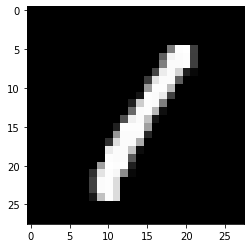

In [4]:
plt.imshow(np.transpose(dat[100, :, :, :], (1,2,0)), cmap='gray')
plt.show()

In [5]:
def softmax(x):
    return np.exp(x)/np.sum(np.exp(x))

def accuracy(true, predicted):
    return torch.mean((true==torch.argmax(predicted, dim=1)).type(torch.FloatTensor)).numpy()

# Questions 1-4
Below we first implement a CNN as required

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, 5, 1, 2, bias=True)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 4, 5, 1, 2, bias=True)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.flatten = Flatten()
        self.linear1 = nn.Linear(196, 49, bias=True)
        self.linear2 = nn.Linear(49, 10, bias=True)

    def forward(self, x):
        x = relu(self.conv1(x))
        x = self.pool1(x)
        x = relu(self.conv2(x))
        x = self.pool2(x)
        x = self.flatten(x)
        x = relu(self.linear1(x))
        x = self.linear2(x)
        return x

    def activ(self, x):
        return [self.conv1(x).detach().numpy()[0, :, :, :], self.conv2(self.pool1(relu(self.conv1(x)))).detach().numpy()[0, :, :, :]]

    def bottleneck(self, x):
        return self.flatten(self.pool2(relu(self.conv2(self.pool1(relu(self.conv1(x))))))).detach().numpy()

Below we train the CNN using Vanilla SGD. Cross entropy loss plot is printed at end. Accuracy is reported after each epoch. TSNE visualisation of bottleneck layer output is provided after first and last epoch. Activations outputted from conv layers are plotted for 1 image after each epoch. Two minibatch sizes: 5 and 50 are tested with.

Currently training on epoch: 0
Train accuracy = 0.095
Test accuracy = 0.1


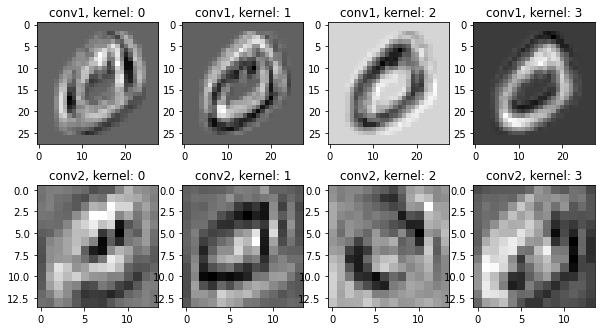

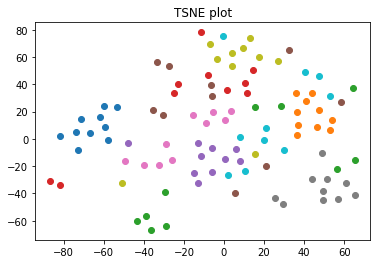

Currently training on epoch: 1
Train accuracy = 0.097
Test accuracy = 0.11


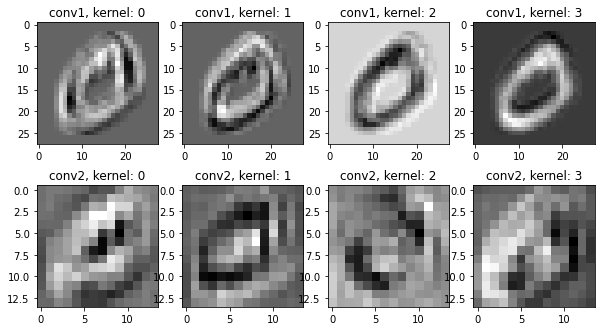

Currently training on epoch: 2
Train accuracy = 0.101
Test accuracy = 0.14


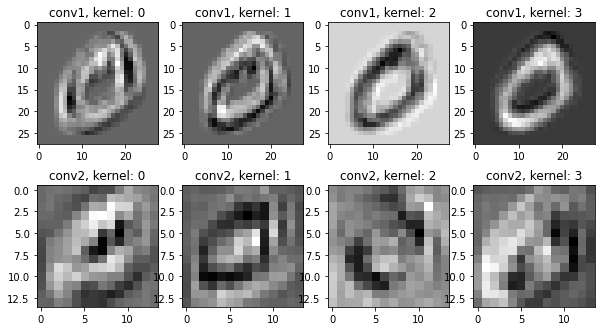

Currently training on epoch: 3
Train accuracy = 0.106
Test accuracy = 0.14


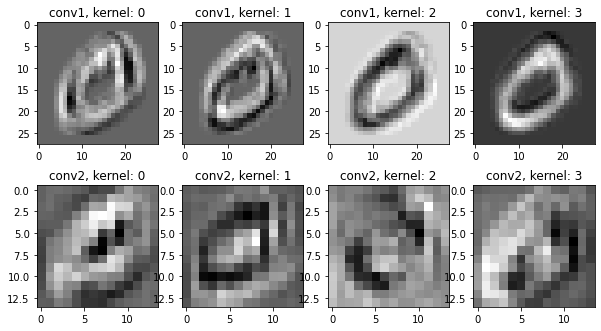

Currently training on epoch: 4
Train accuracy = 0.111
Test accuracy = 0.15


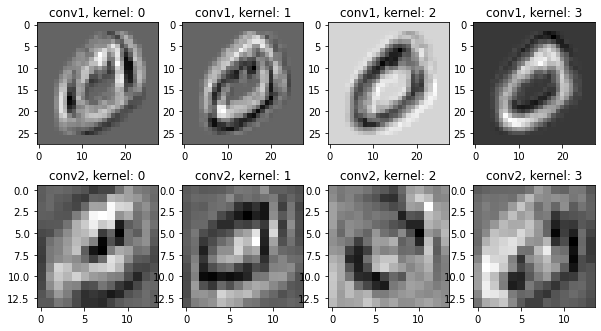

Currently training on epoch: 5
Train accuracy = 0.119
Test accuracy = 0.16


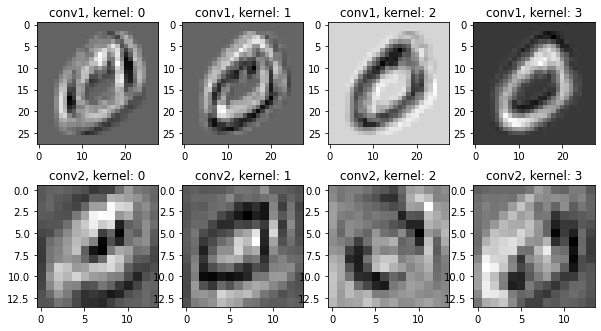

Currently training on epoch: 6
Train accuracy = 0.131
Test accuracy = 0.17


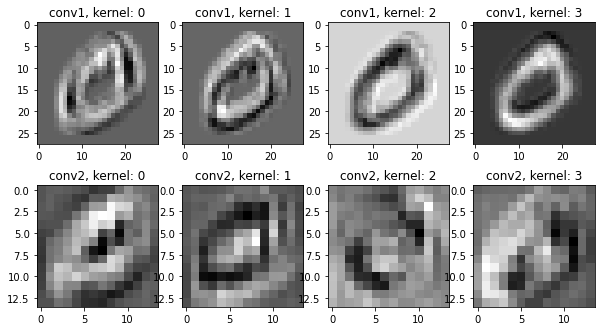

Currently training on epoch: 7
Train accuracy = 0.149
Test accuracy = 0.19


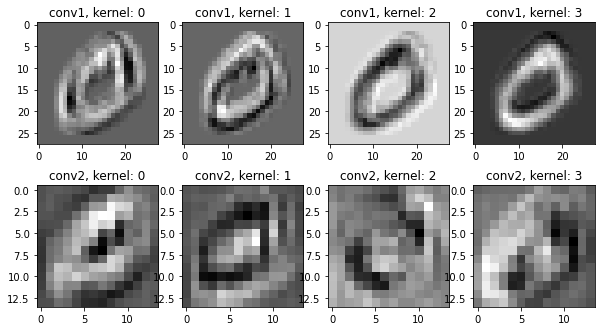

Currently training on epoch: 8
Train accuracy = 0.186
Test accuracy = 0.2


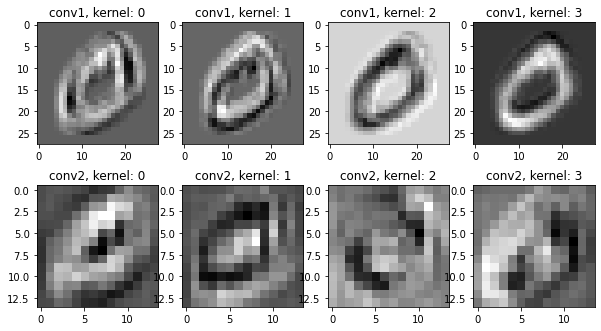

Currently training on epoch: 9
Train accuracy = 0.22
Test accuracy = 0.22


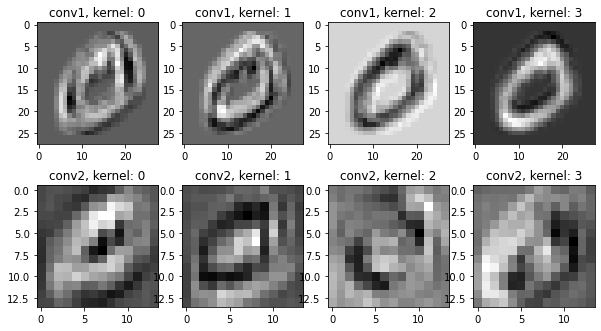

Currently training on epoch: 10
Train accuracy = 0.259
Test accuracy = 0.23


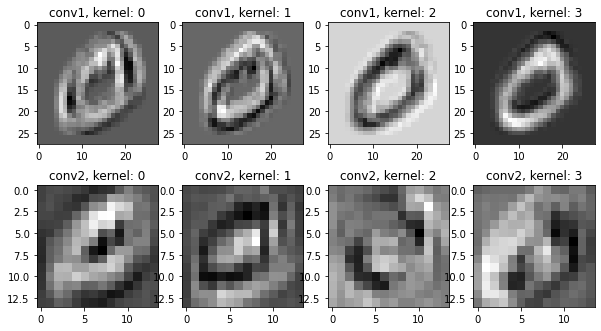

Currently training on epoch: 11
Train accuracy = 0.293
Test accuracy = 0.25


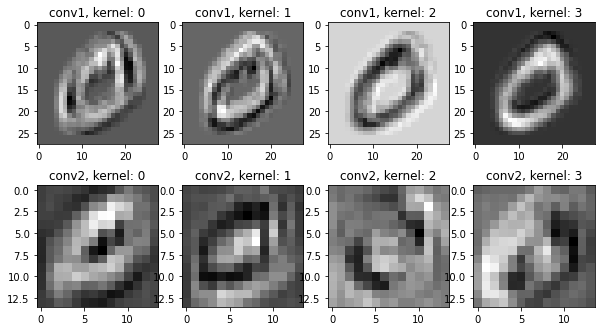

Currently training on epoch: 12
Train accuracy = 0.302
Test accuracy = 0.27


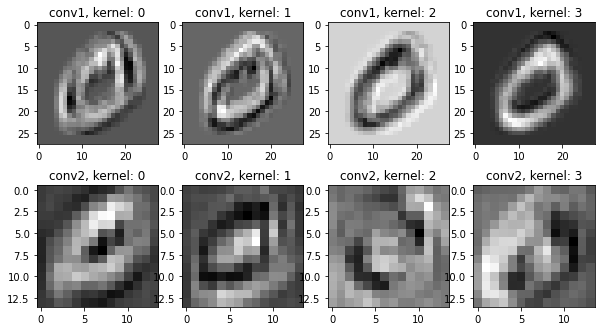

Currently training on epoch: 13
Train accuracy = 0.327
Test accuracy = 0.29


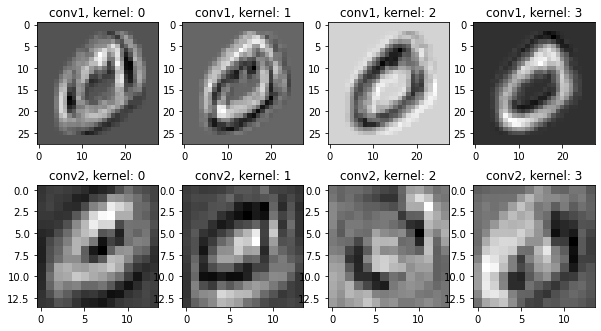

Currently training on epoch: 14
Train accuracy = 0.349
Test accuracy = 0.3


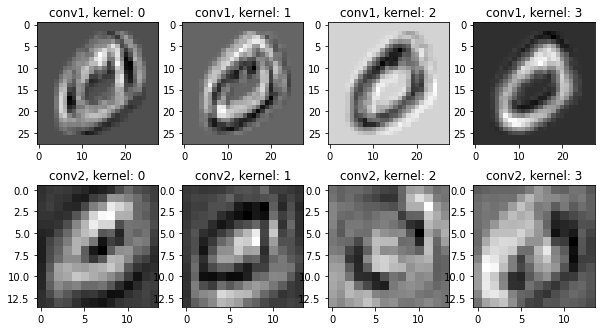

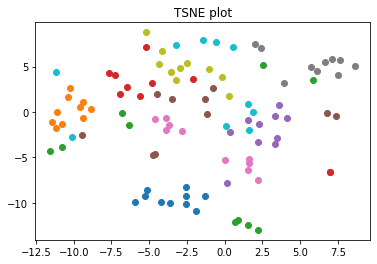

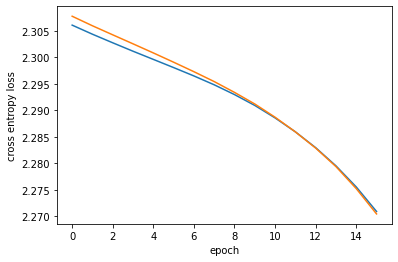

In [7]:
model = CNN()
optim = torch.optim.SGD(model.parameters(), lr=0.001)

epochs = 15
minibatch = 5

loss = CrossEntropyLoss()
loss_train = [loss(model(dat), labs)]
loss_test = [loss(model(test), test_labs)]

for i in range(epochs):
    print("Currently training on epoch:", i)
    indices = np.random.permutation(dat.shape[0])
    for j in range(dat.shape[0]//minibatch):
        optim.zero_grad()
        preds = model(dat[indices[j*minibatch:(j+1)*minibatch], :, :, :])
        loss_ = loss(preds, labs[indices[j*minibatch:(j+1)*minibatch]])
        loss_.backward()
        optim.step()

    preds__ = model(dat)
    loss_train.append(loss(preds__, labs))
    print("Train accuracy =", accuracy(labs, preds__))
    preds__ = model(test)
    loss_test.append(loss(preds__, test_labs))
    print("Test accuracy =", accuracy(test_labs, preds__))

    figure, ax = plt.subplots(2, 4, figsize=(10,5.5))
    for e in range(4):
        ax[0, e].imshow(np.transpose(model.activ(dat[:1, :, :, :])[0], (1,2,0))[:, :, e], cmap='gray')
        ax[0, e].set_title("conv1, kernel: "+str(e))
    for e in range(4):
        ax[1, e].imshow(np.transpose(model.activ(dat[:1, :, :, :])[1], (1,2,0))[:, :, e], cmap='gray')
        ax[1, e].set_title("conv2, kernel: "+str(e))
    plt.show()

    if i == 0 or i == epochs-1:
        a = TSNE(n_components=2, init='random', perplexity=20, n_iter=5000).fit_transform(model.bottleneck(test))
        for o in range(10):
            plt.scatter(a[10*o:10*o+10, 0], a[10*o:10*o+10, 1], marker='o')
        plt.title("TSNE plot")
        plt.show()

plt.plot(np.arange(epochs+1), loss_train)
plt.plot(np.arange(epochs+1), loss_test)
plt.xlabel("epoch")
plt.ylabel("cross entropy loss")
plt.show()

Currently training on epoch: 0
Train accuracy = 0.118
Test accuracy = 0.1


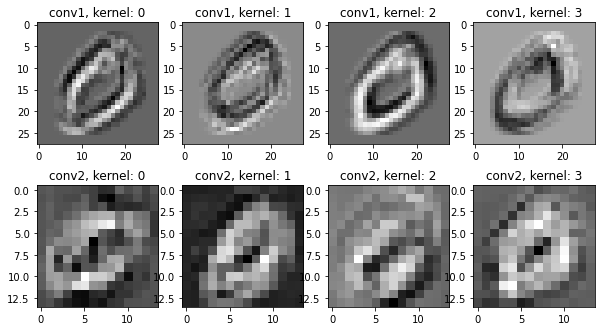

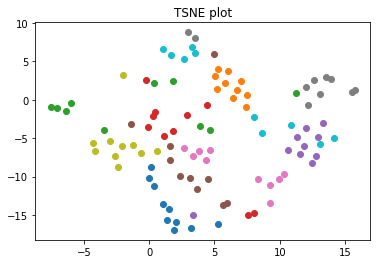

Currently training on epoch: 1
Train accuracy = 0.121
Test accuracy = 0.1


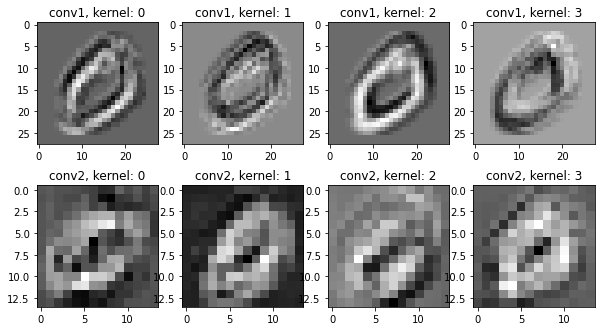

Currently training on epoch: 2
Train accuracy = 0.121
Test accuracy = 0.1


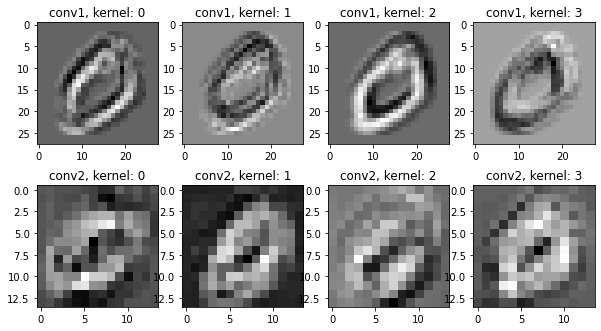

Currently training on epoch: 3
Train accuracy = 0.121
Test accuracy = 0.1


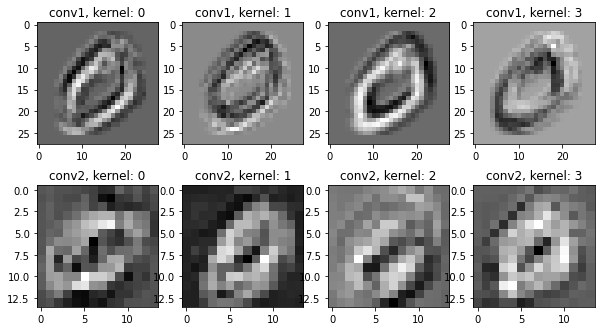

Currently training on epoch: 4
Train accuracy = 0.122
Test accuracy = 0.1


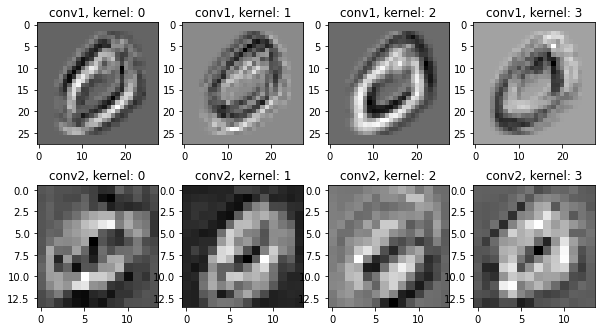

Currently training on epoch: 5
Train accuracy = 0.122
Test accuracy = 0.1


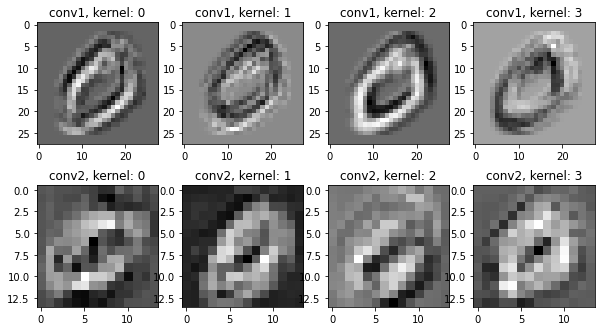

Currently training on epoch: 6
Train accuracy = 0.121
Test accuracy = 0.1


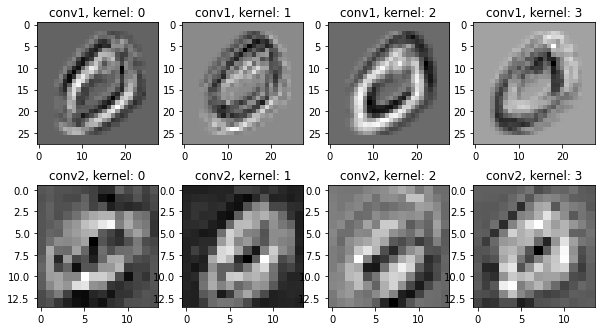

Currently training on epoch: 7
Train accuracy = 0.122
Test accuracy = 0.1


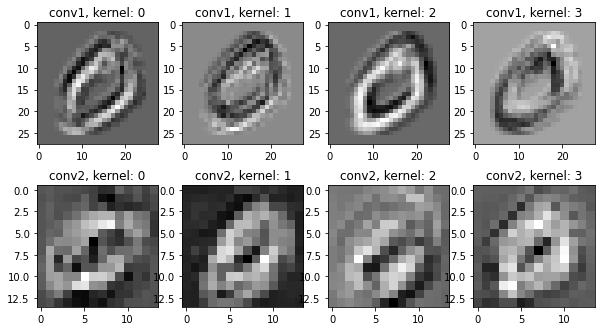

Currently training on epoch: 8
Train accuracy = 0.123
Test accuracy = 0.1


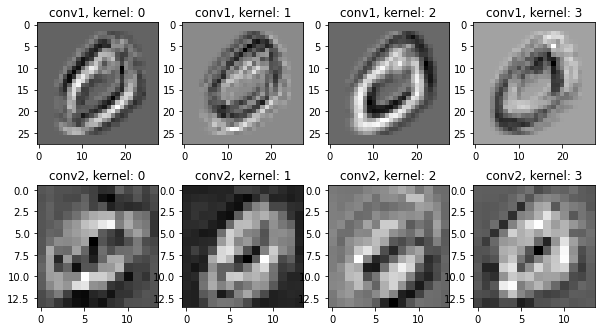

Currently training on epoch: 9
Train accuracy = 0.123
Test accuracy = 0.1


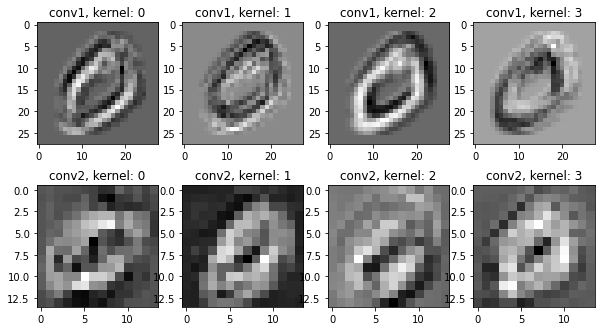

Currently training on epoch: 10
Train accuracy = 0.127
Test accuracy = 0.1


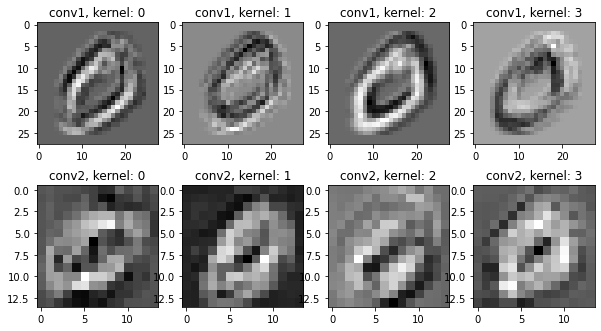

Currently training on epoch: 11
Train accuracy = 0.131
Test accuracy = 0.1


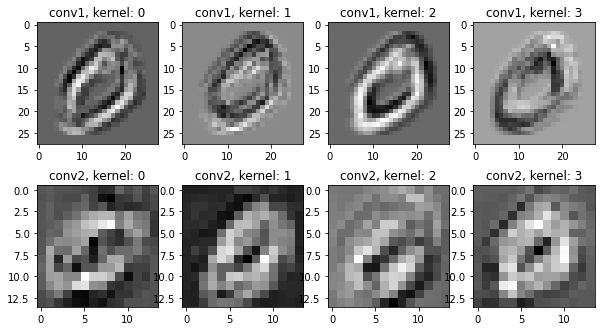

Currently training on epoch: 12
Train accuracy = 0.13
Test accuracy = 0.09


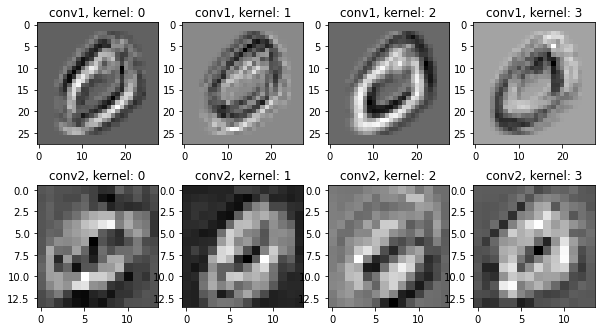

Currently training on epoch: 13
Train accuracy = 0.13
Test accuracy = 0.09


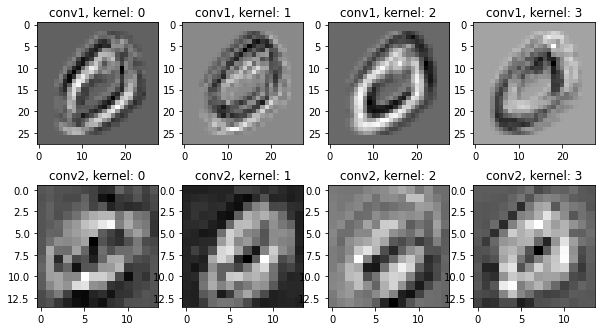

Currently training on epoch: 14
Train accuracy = 0.13
Test accuracy = 0.1


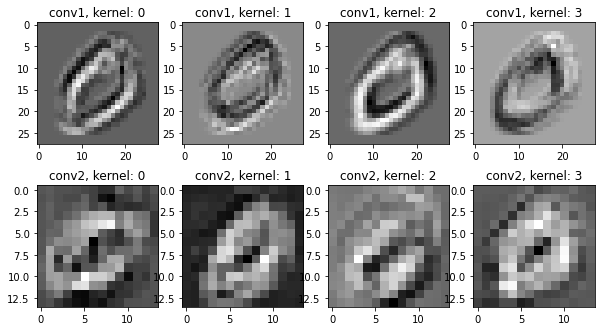

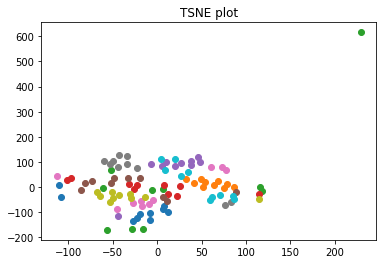

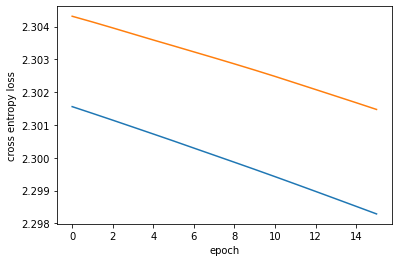

In [8]:
model = CNN()
optim = torch.optim.SGD(model.parameters(), lr=0.001)

epochs = 15
minibatch = 50

loss = CrossEntropyLoss()
loss_train = [loss(model(dat), labs)]
loss_test = [loss(model(test), test_labs)]

for i in range(epochs):
    print("Currently training on epoch:", i)
    indices = np.random.permutation(dat.shape[0])
    for j in range(dat.shape[0]//minibatch):
        optim.zero_grad()
        preds = model(dat[indices[j*minibatch:(j+1)*minibatch], :, :, :])
        loss_ = loss(preds, labs[indices[j*minibatch:(j+1)*minibatch]])
        loss_.backward()
        optim.step()

    preds__ = model(dat)
    loss_train.append(loss(preds__, labs))
    print("Train accuracy =", accuracy(labs, preds__))
    preds__ = model(test)
    loss_test.append(loss(preds__, test_labs))
    print("Test accuracy =", accuracy(test_labs, preds__))

    figure, ax = plt.subplots(2, 4, figsize=(10,5.5))
    for e in range(4):
        ax[0, e].imshow(np.transpose(model.activ(dat[:1, :, :, :])[0], (1,2,0))[:, :, e], cmap='gray')
        ax[0, e].set_title("conv1, kernel: "+str(e))
    for e in range(4):
        ax[1, e].imshow(np.transpose(model.activ(dat[:1, :, :, :])[1], (1,2,0))[:, :, e], cmap='gray')
        ax[1, e].set_title("conv2, kernel: "+str(e))
    plt.show()

    if i == 0 or i == epochs-1:
        a = TSNE(n_components=2, init='random', perplexity=20, n_iter=5000).fit_transform(model.bottleneck(test))
        for o in range(10):
            plt.scatter(a[10*o:10*o+10, 0], a[10*o:10*o+10, 1], marker='o')
        plt.title("TSNE plot")
        plt.show()

plt.plot(np.arange(epochs+1), loss_train)
plt.plot(np.arange(epochs+1), loss_test)
plt.xlabel("epoch")
plt.ylabel("cross entropy loss")
plt.show()

Below we train the CNN using SGD with Momentum. Cross entropy loss plot is printed at end. Accuracy is reported after each epoch. TSNE visualisation of bottleneck layer output is provided after first and last epoch. Activations outputted from conv layers are plotted for 1 image after each epoch. Two minibatch sizes: 5 and 50 are tested with.

Currently training on epoch: 0
Train accuracy = 0.118
Test accuracy = 0.12


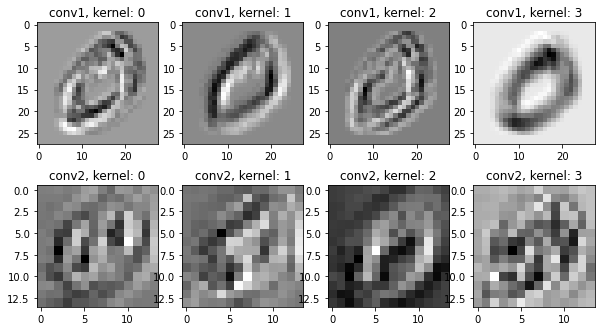

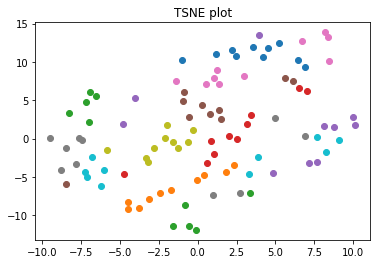

Currently training on epoch: 1
Train accuracy = 0.262
Test accuracy = 0.22


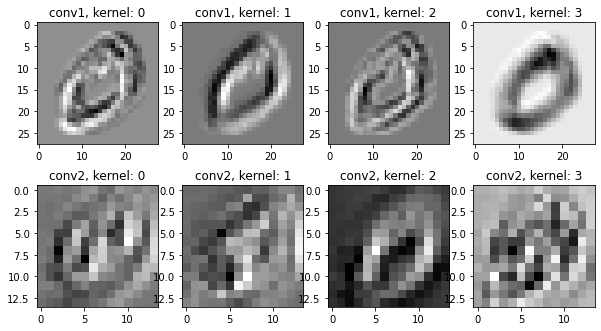

Currently training on epoch: 2
Train accuracy = 0.393
Test accuracy = 0.35


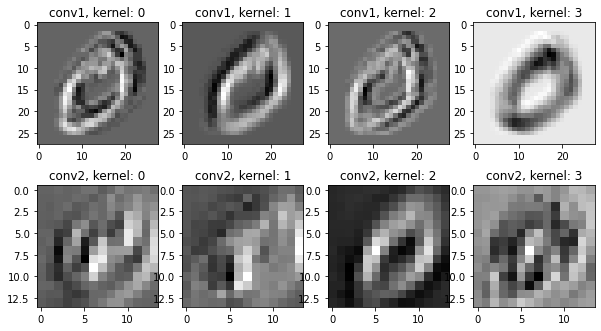

Currently training on epoch: 3
Train accuracy = 0.592
Test accuracy = 0.53


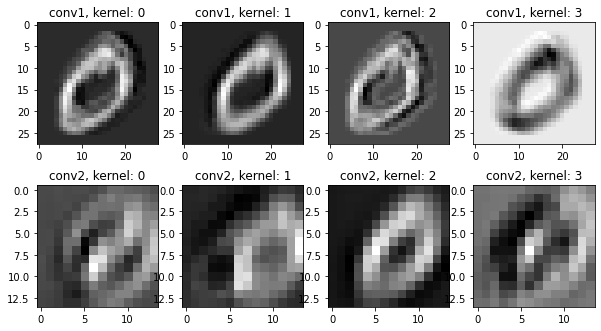

Currently training on epoch: 4
Train accuracy = 0.707
Test accuracy = 0.61


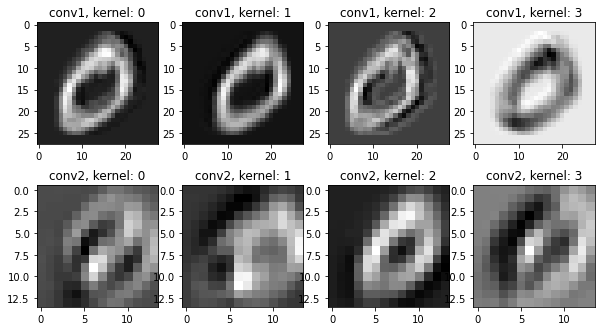

Currently training on epoch: 5
Train accuracy = 0.787
Test accuracy = 0.63


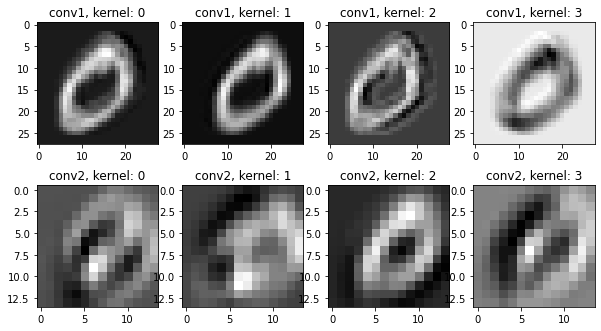

Currently training on epoch: 6
Train accuracy = 0.851
Test accuracy = 0.81


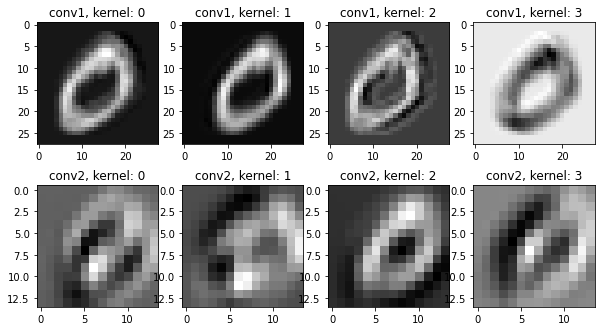

Currently training on epoch: 7
Train accuracy = 0.884
Test accuracy = 0.9


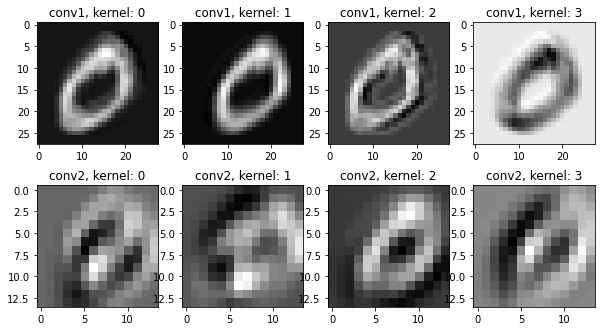

Currently training on epoch: 8
Train accuracy = 0.879
Test accuracy = 0.85


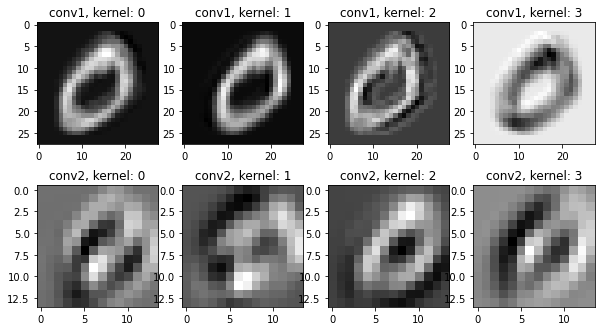

Currently training on epoch: 9
Train accuracy = 0.903
Test accuracy = 0.88


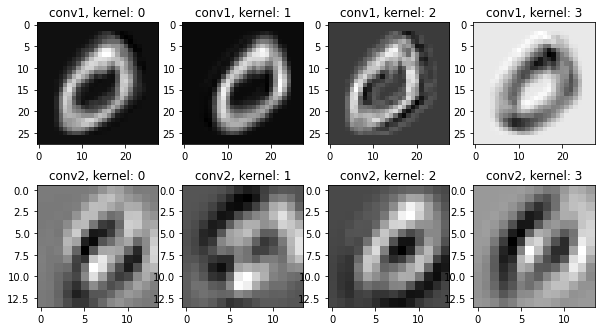

Currently training on epoch: 10
Train accuracy = 0.895
Test accuracy = 0.89


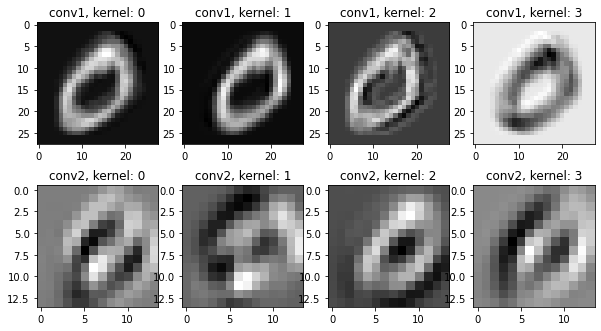

Currently training on epoch: 11
Train accuracy = 0.929
Test accuracy = 0.92


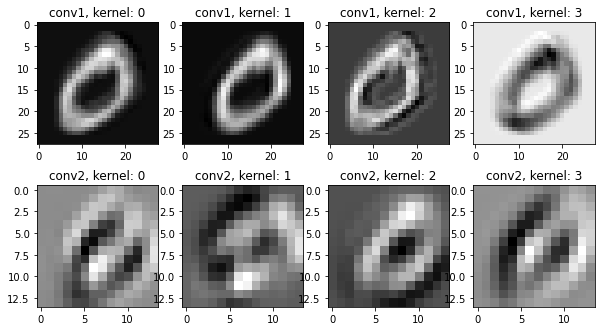

Currently training on epoch: 12
Train accuracy = 0.904
Test accuracy = 0.86


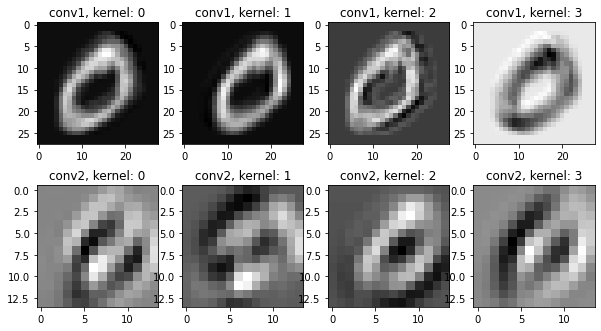

Currently training on epoch: 13
Train accuracy = 0.946
Test accuracy = 0.92


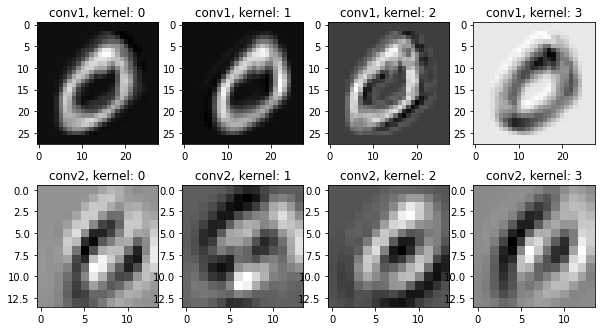

Currently training on epoch: 14
Train accuracy = 0.953
Test accuracy = 0.92


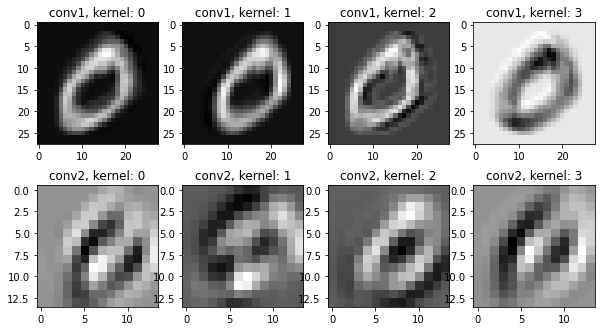

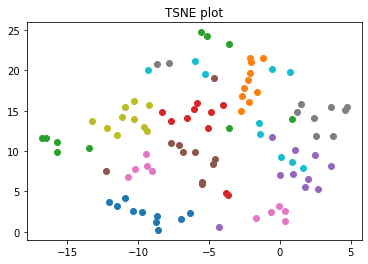

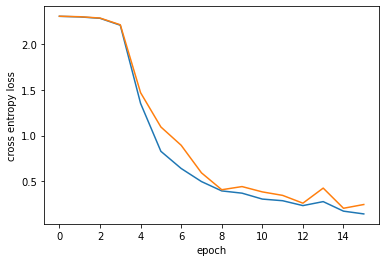

In [9]:
model = CNN()
optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

epochs = 15
minibatch = 5

loss = CrossEntropyLoss()
loss_train = [loss(model(dat), labs)]
loss_test = [loss(model(test), test_labs)]

for i in range(epochs):
    print("Currently training on epoch:", i)
    indices = np.random.permutation(dat.shape[0])
    for j in range(dat.shape[0]//minibatch):
        optim.zero_grad()
        preds = model(dat[indices[j*minibatch:(j+1)*minibatch], :, :, :])
        loss_ = loss(preds, labs[indices[j*minibatch:(j+1)*minibatch]])
        loss_.backward()
        optim.step()

    preds__ = model(dat)
    loss_train.append(loss(preds__, labs))
    print("Train accuracy =", accuracy(labs, preds__))
    preds__ = model(test)
    loss_test.append(loss(preds__, test_labs))
    print("Test accuracy =", accuracy(test_labs, preds__))

    figure, ax = plt.subplots(2, 4, figsize=(10,5.5))
    for e in range(4):
        ax[0, e].imshow(np.transpose(model.activ(dat[:1, :, :, :])[0], (1,2,0))[:, :, e], cmap='gray')
        ax[0, e].set_title("conv1, kernel: "+str(e))
    for e in range(4):
        ax[1, e].imshow(np.transpose(model.activ(dat[:1, :, :, :])[1], (1,2,0))[:, :, e], cmap='gray')
        ax[1, e].set_title("conv2, kernel: "+str(e))
    plt.show()

    if i == 0 or i == epochs-1:
        a = TSNE(n_components=2, init='random', perplexity=20, n_iter=5000).fit_transform(model.bottleneck(test))
        for o in range(10):
            plt.scatter(a[10*o:10*o+10, 0], a[10*o:10*o+10, 1], marker='o')
        plt.title("TSNE plot")
        plt.show()

plt.plot(np.arange(epochs+1), loss_train)
plt.plot(np.arange(epochs+1), loss_test)
plt.xlabel("epoch")
plt.ylabel("cross entropy loss")
plt.show()

Currently training on epoch: 0
Train accuracy = 0.093
Test accuracy = 0.08


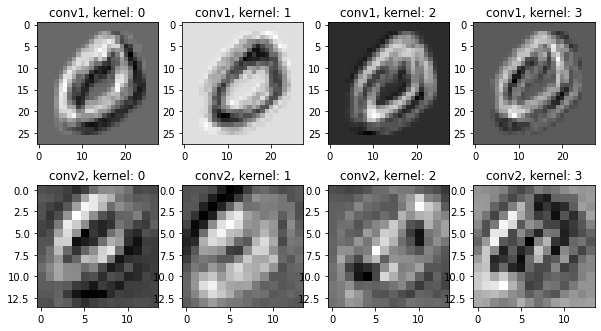

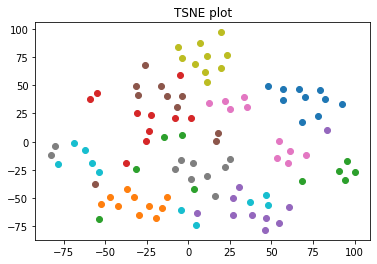

Currently training on epoch: 1
Train accuracy = 0.102
Test accuracy = 0.07


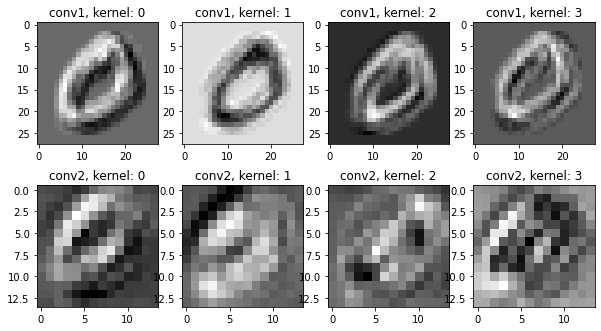

Currently training on epoch: 2
Train accuracy = 0.106
Test accuracy = 0.08


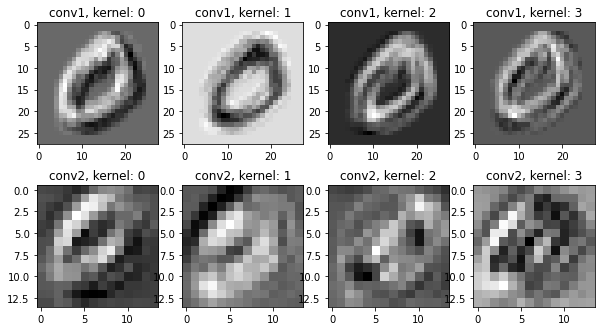

Currently training on epoch: 3
Train accuracy = 0.113
Test accuracy = 0.07


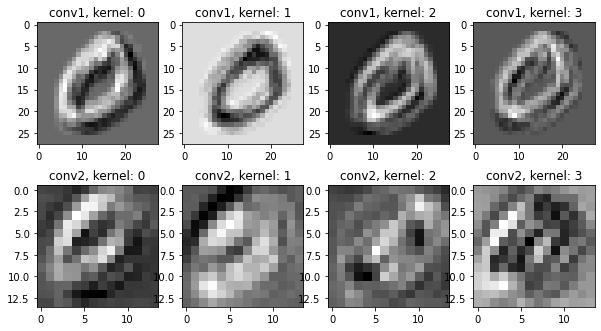

Currently training on epoch: 4
Train accuracy = 0.118
Test accuracy = 0.08


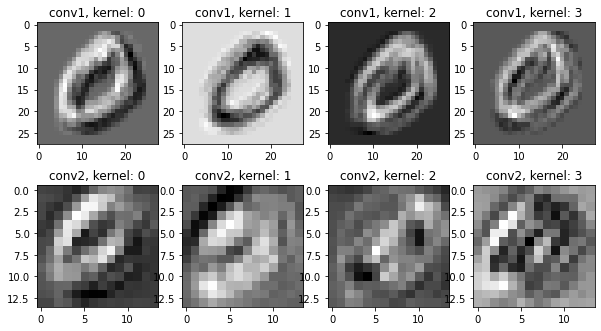

Currently training on epoch: 5
Train accuracy = 0.128
Test accuracy = 0.09


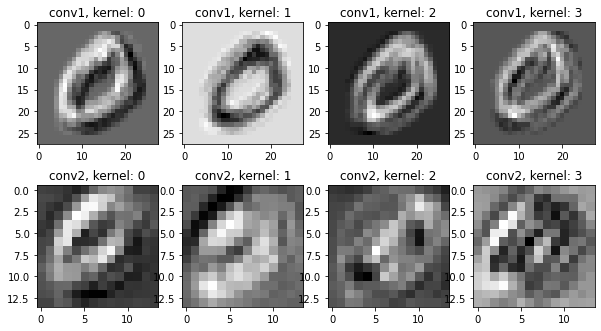

Currently training on epoch: 6
Train accuracy = 0.131
Test accuracy = 0.09


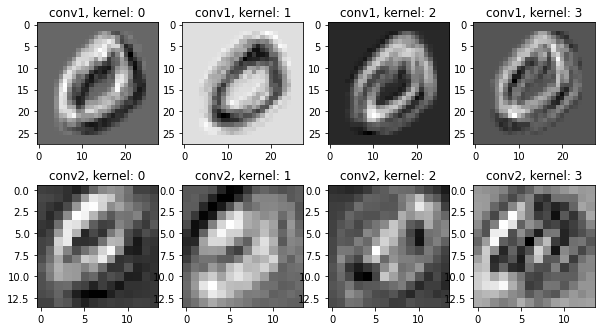

Currently training on epoch: 7
Train accuracy = 0.139
Test accuracy = 0.09


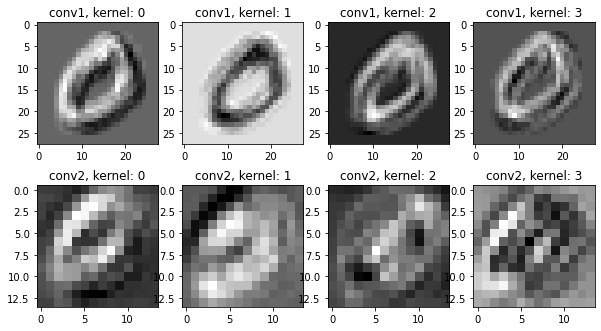

Currently training on epoch: 8
Train accuracy = 0.152
Test accuracy = 0.11


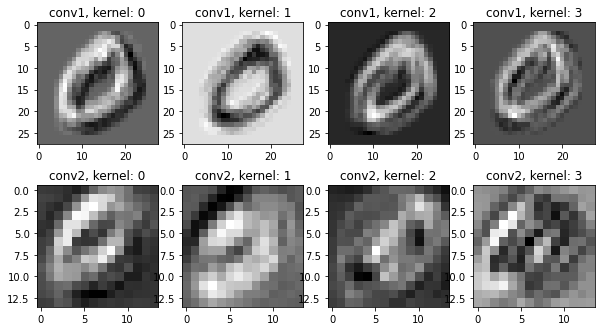

Currently training on epoch: 9
Train accuracy = 0.167
Test accuracy = 0.13


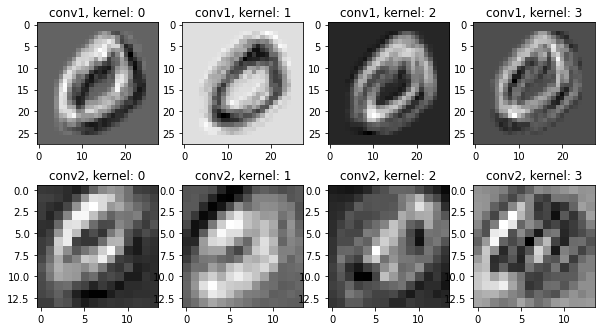

Currently training on epoch: 10
Train accuracy = 0.181
Test accuracy = 0.14


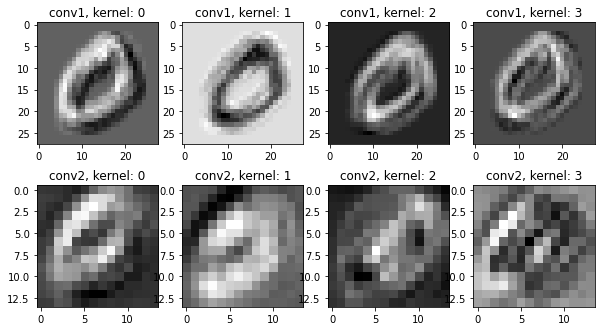

Currently training on epoch: 11
Train accuracy = 0.2
Test accuracy = 0.18


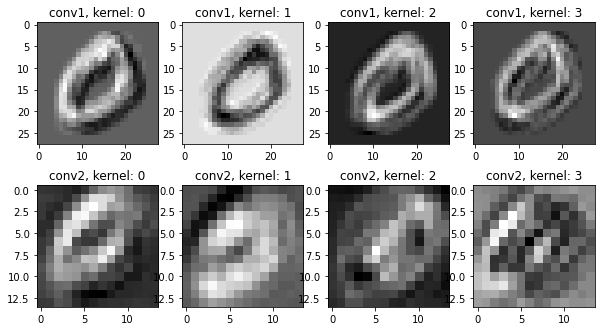

Currently training on epoch: 12
Train accuracy = 0.244
Test accuracy = 0.22


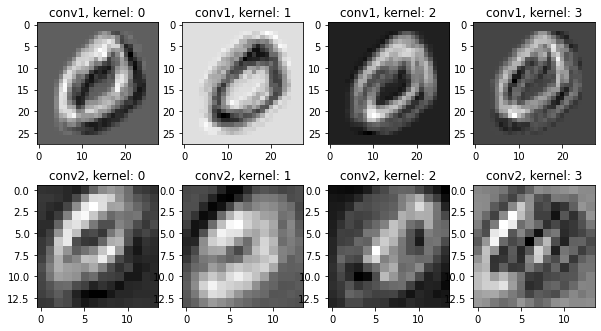

Currently training on epoch: 13
Train accuracy = 0.311
Test accuracy = 0.32


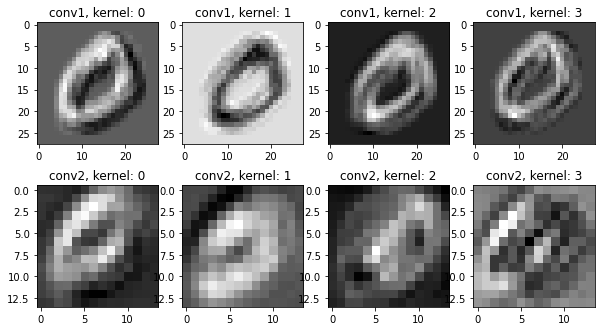

Currently training on epoch: 14
Train accuracy = 0.361
Test accuracy = 0.35


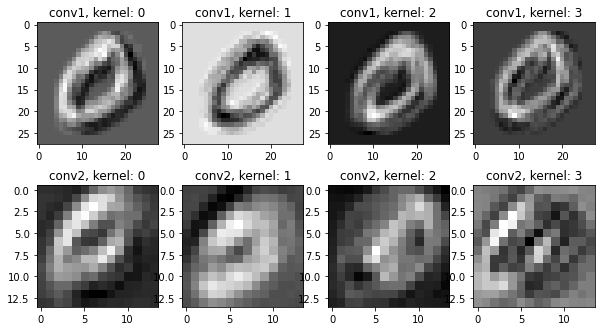

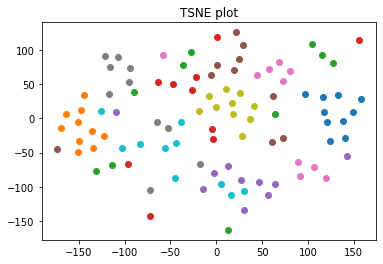

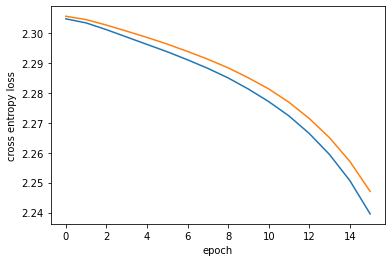

In [10]:
model = CNN()
optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

epochs = 15
minibatch = 50

loss = CrossEntropyLoss()
loss_train = [loss(model(dat), labs)]
loss_test = [loss(model(test), test_labs)]

for i in range(epochs):
    print("Currently training on epoch:", i)
    indices = np.random.permutation(dat.shape[0])
    for j in range(dat.shape[0]//minibatch):
        optim.zero_grad()
        preds = model(dat[indices[j*minibatch:(j+1)*minibatch], :, :, :])
        loss_ = loss(preds, labs[indices[j*minibatch:(j+1)*minibatch]])
        loss_.backward()
        optim.step()

    preds__ = model(dat)
    loss_train.append(loss(preds__, labs))
    print("Train accuracy =", accuracy(labs, preds__))
    preds__ = model(test)
    loss_test.append(loss(preds__, test_labs))
    print("Test accuracy =", accuracy(test_labs, preds__))

    figure, ax = plt.subplots(2, 4, figsize=(10,5.5))
    for e in range(4):
        ax[0, e].imshow(np.transpose(model.activ(dat[:1, :, :, :])[0], (1,2,0))[:, :, e], cmap='gray')
        ax[0, e].set_title("conv1, kernel: "+str(e))
    for e in range(4):
        ax[1, e].imshow(np.transpose(model.activ(dat[:1, :, :, :])[1], (1,2,0))[:, :, e], cmap='gray')
        ax[1, e].set_title("conv2, kernel: "+str(e))
    plt.show()

    if i == 0 or i == epochs-1:
        a = TSNE(n_components=2, init='random', perplexity=20, n_iter=5000).fit_transform(model.bottleneck(test))
        for o in range(10):
            plt.scatter(a[10*o:10*o+10, 0], a[10*o:10*o+10, 1], marker='o')
        plt.title("TSNE plot")
        plt.show()

plt.plot(np.arange(epochs+1), loss_train)
plt.plot(np.arange(epochs+1), loss_test)
plt.xlabel("epoch")
plt.ylabel("cross entropy loss")
plt.show()

Below we train the CNN using RMSprop. Cross entropy loss plot is printed at end. Accuracy is reported after each epoch. TSNE visualisation of bottleneck layer output is provided after first and last epoch. Activations outputted from conv layers are plotted for 1 image after each epoch. Two minibatch sizes: 5 and 50 are tested with.

Currently training on epoch: 0
Train accuracy = 0.699
Test accuracy = 0.64


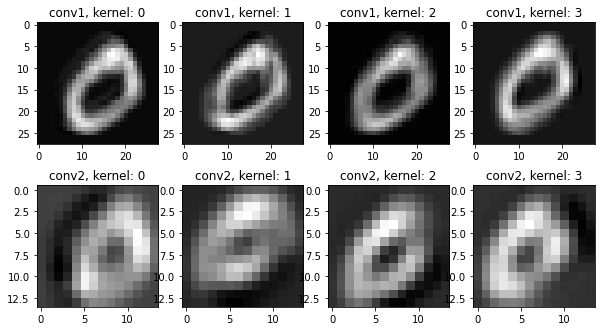

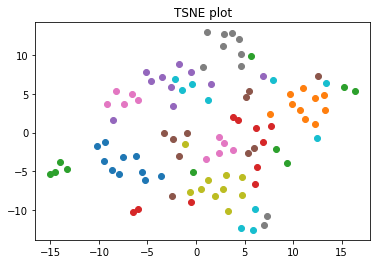

Currently training on epoch: 1
Train accuracy = 0.818
Test accuracy = 0.78


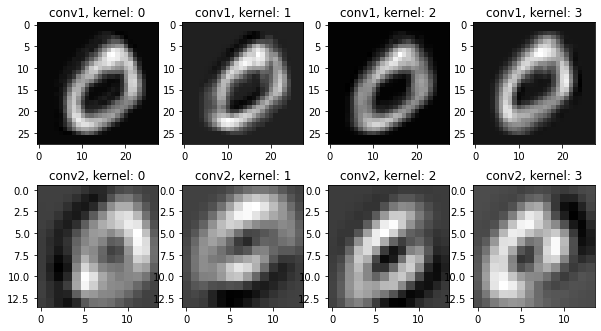

Currently training on epoch: 2
Train accuracy = 0.878
Test accuracy = 0.8


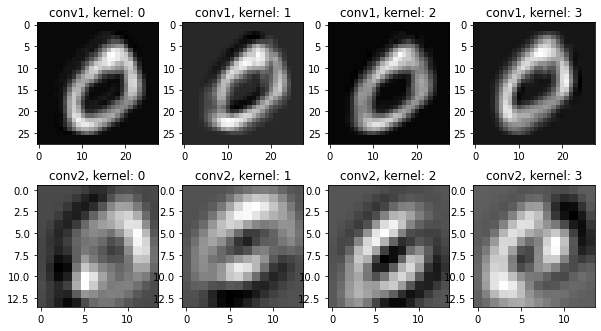

Currently training on epoch: 3
Train accuracy = 0.895
Test accuracy = 0.86


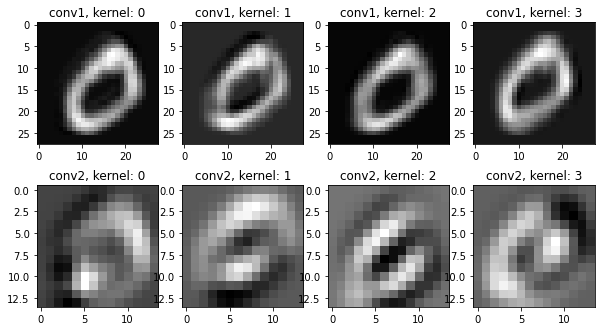

Currently training on epoch: 4
Train accuracy = 0.931
Test accuracy = 0.92


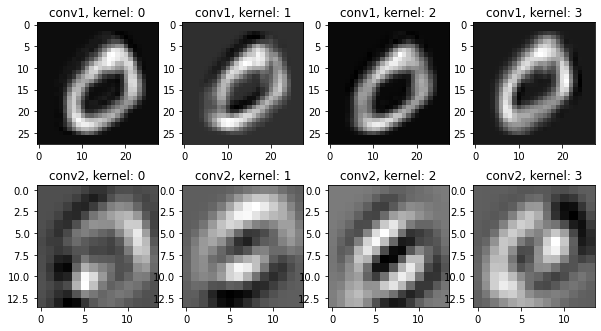

Currently training on epoch: 5
Train accuracy = 0.916
Test accuracy = 0.88


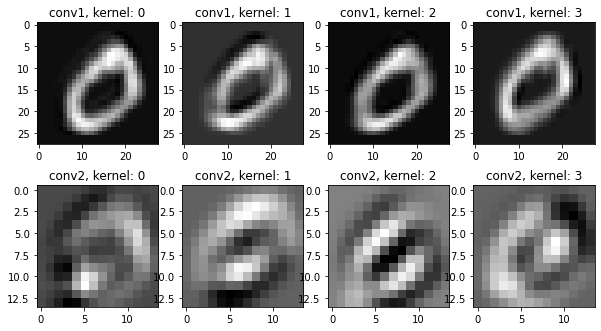

Currently training on epoch: 6
Train accuracy = 0.945
Test accuracy = 0.94


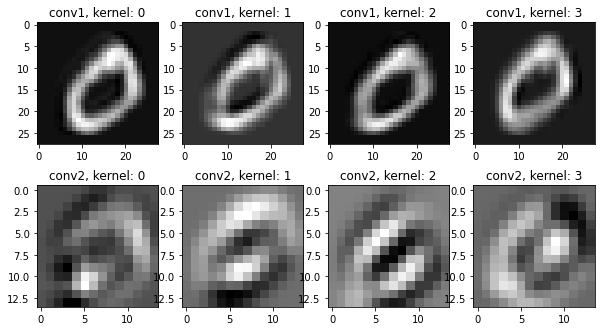

Currently training on epoch: 7
Train accuracy = 0.954
Test accuracy = 0.95


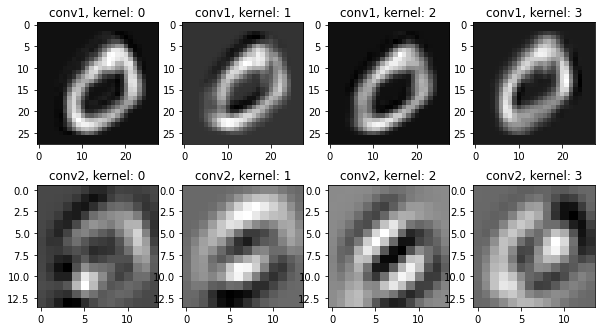

Currently training on epoch: 8
Train accuracy = 0.959
Test accuracy = 0.95


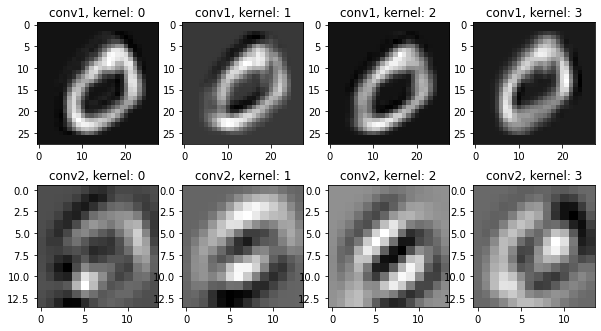

Currently training on epoch: 9
Train accuracy = 0.959
Test accuracy = 0.95


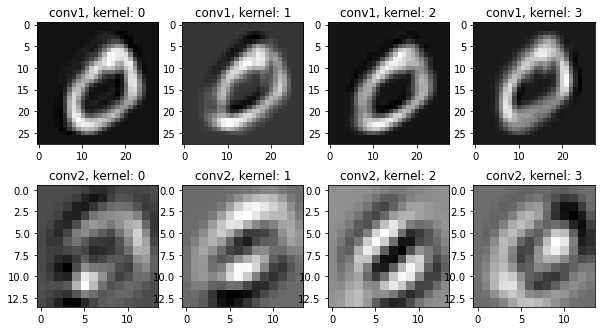

Currently training on epoch: 10
Train accuracy = 0.955
Test accuracy = 0.93


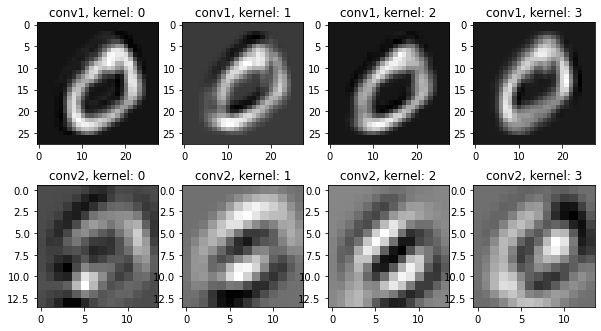

Currently training on epoch: 11
Train accuracy = 0.973
Test accuracy = 0.95


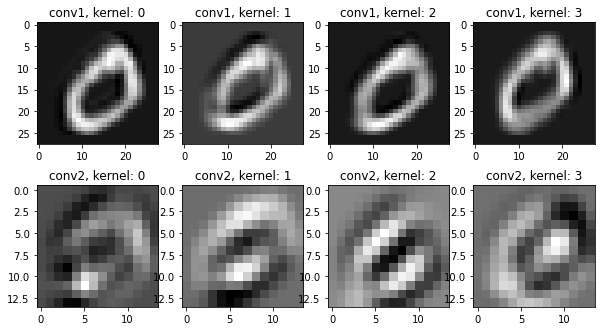

Currently training on epoch: 12
Train accuracy = 0.979
Test accuracy = 0.95


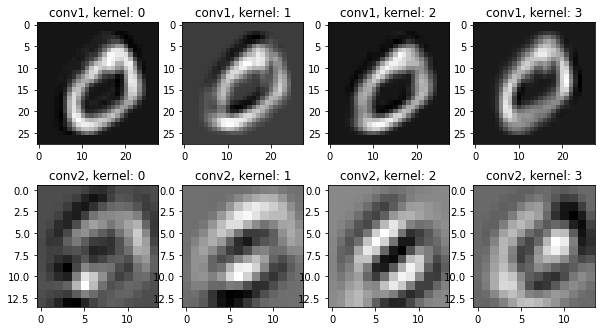

Currently training on epoch: 13
Train accuracy = 0.986
Test accuracy = 0.97


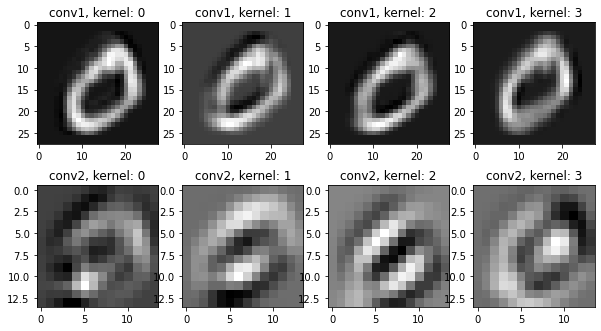

Currently training on epoch: 14
Train accuracy = 0.985
Test accuracy = 0.94


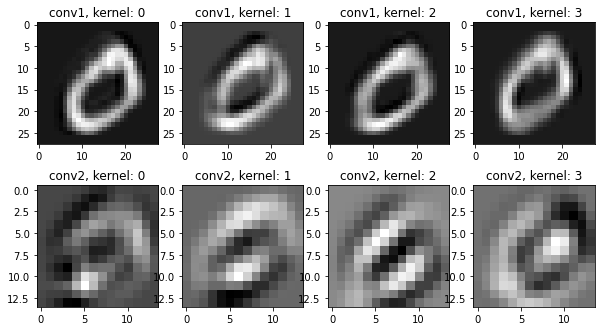

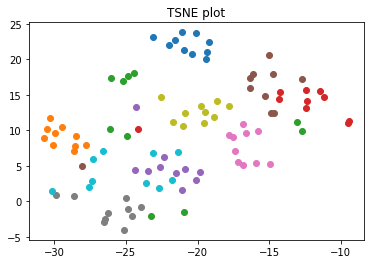

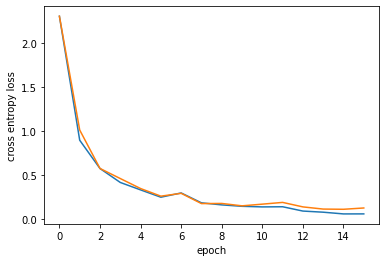

In [11]:
model = CNN()
optim = torch.optim.RMSprop(model.parameters(), lr=0.001, alpha=0.9)

epochs = 15
minibatch = 5

loss = CrossEntropyLoss()
loss_train = [loss(model(dat), labs)]
loss_test = [loss(model(test), test_labs)]

for i in range(epochs):
    print("Currently training on epoch:", i)
    indices = np.random.permutation(dat.shape[0])
    for j in range(dat.shape[0]//minibatch):
        optim.zero_grad()
        preds = model(dat[indices[j*minibatch:(j+1)*minibatch], :, :, :])
        loss_ = loss(preds, labs[indices[j*minibatch:(j+1)*minibatch]])
        loss_.backward()
        optim.step()

    preds__ = model(dat)
    loss_train.append(loss(preds__, labs))
    print("Train accuracy =", accuracy(labs, preds__))
    preds__ = model(test)
    loss_test.append(loss(preds__, test_labs))
    print("Test accuracy =", accuracy(test_labs, preds__))

    figure, ax = plt.subplots(2, 4, figsize=(10,5.5))
    for e in range(4):
        ax[0, e].imshow(np.transpose(model.activ(dat[:1, :, :, :])[0], (1,2,0))[:, :, e], cmap='gray')
        ax[0, e].set_title("conv1, kernel: "+str(e))
    for e in range(4):
        ax[1, e].imshow(np.transpose(model.activ(dat[:1, :, :, :])[1], (1,2,0))[:, :, e], cmap='gray')
        ax[1, e].set_title("conv2, kernel: "+str(e))
    plt.show()

    if i == 0 or i == epochs-1:
        a = TSNE(n_components=2, init='random', perplexity=20, n_iter=5000).fit_transform(model.bottleneck(test))
        for o in range(10):
            plt.scatter(a[10*o:10*o+10, 0], a[10*o:10*o+10, 1], marker='o')
        plt.title("TSNE plot")
        plt.show()

plt.plot(np.arange(epochs+1), loss_train)
plt.plot(np.arange(epochs+1), loss_test)
plt.xlabel("epoch")
plt.ylabel("cross entropy loss")
plt.show()

Currently training on epoch: 0
Train accuracy = 0.443
Test accuracy = 0.42


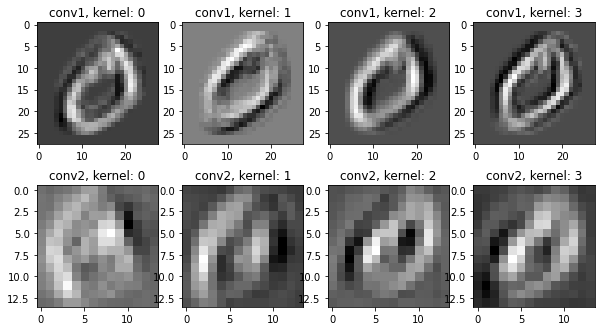

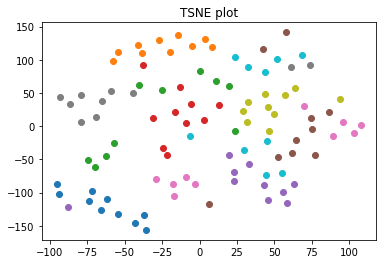

Currently training on epoch: 1
Train accuracy = 0.539
Test accuracy = 0.45


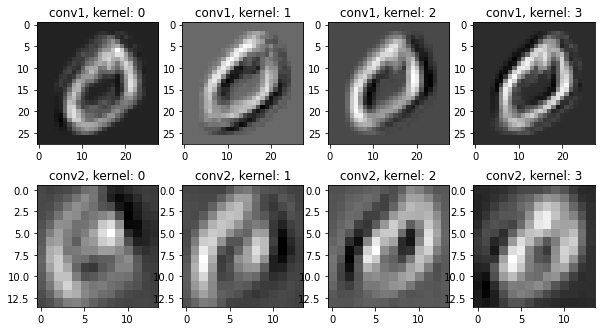

Currently training on epoch: 2
Train accuracy = 0.665
Test accuracy = 0.63


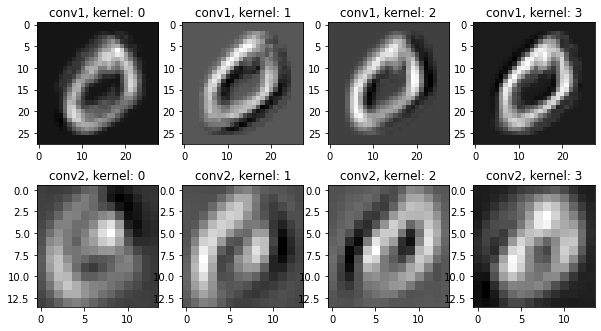

Currently training on epoch: 3
Train accuracy = 0.738
Test accuracy = 0.68


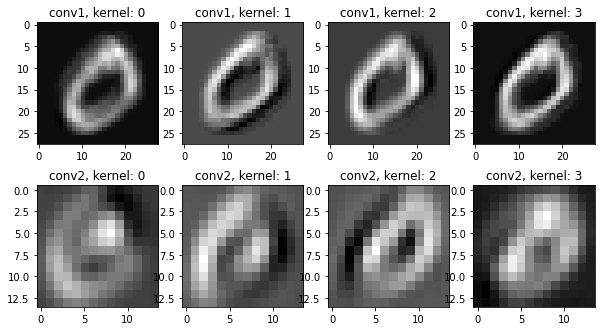

Currently training on epoch: 4
Train accuracy = 0.787
Test accuracy = 0.68


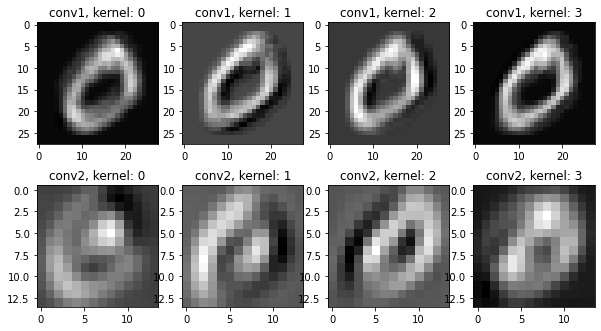

Currently training on epoch: 5
Train accuracy = 0.797
Test accuracy = 0.77


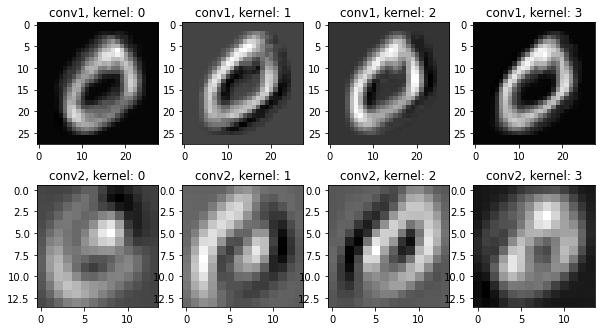

Currently training on epoch: 6
Train accuracy = 0.831
Test accuracy = 0.82


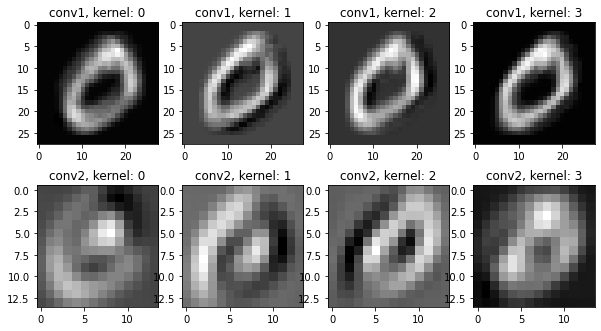

Currently training on epoch: 7
Train accuracy = 0.866
Test accuracy = 0.85


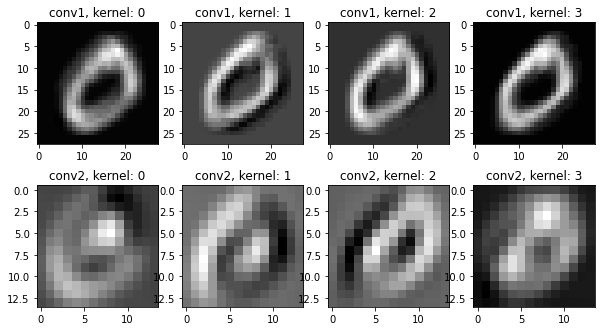

Currently training on epoch: 8
Train accuracy = 0.878
Test accuracy = 0.88


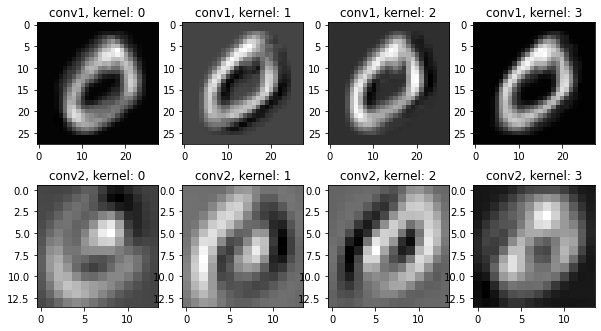

Currently training on epoch: 9
Train accuracy = 0.891
Test accuracy = 0.87


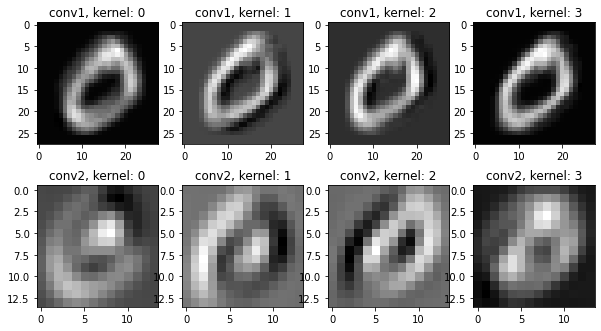

Currently training on epoch: 10
Train accuracy = 0.905
Test accuracy = 0.87


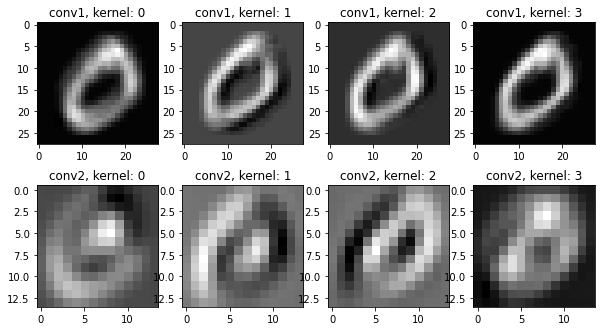

Currently training on epoch: 11
Train accuracy = 0.821
Test accuracy = 0.78


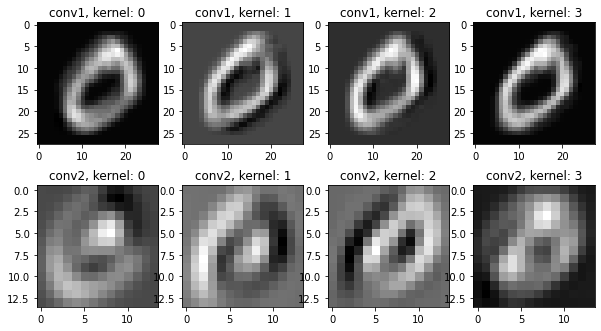

Currently training on epoch: 12
Train accuracy = 0.911
Test accuracy = 0.87


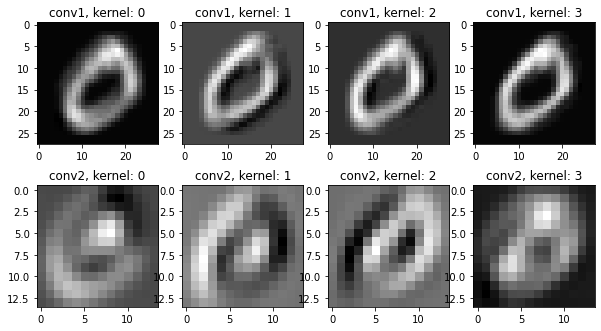

Currently training on epoch: 13
Train accuracy = 0.919
Test accuracy = 0.9


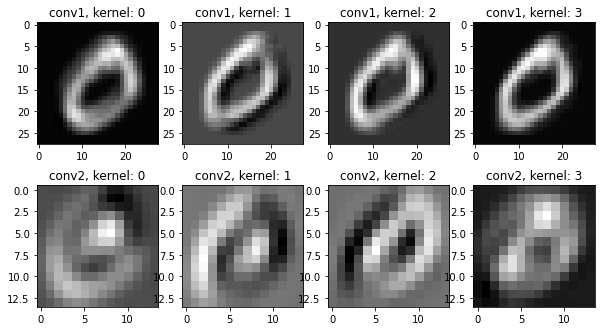

Currently training on epoch: 14
Train accuracy = 0.918
Test accuracy = 0.9


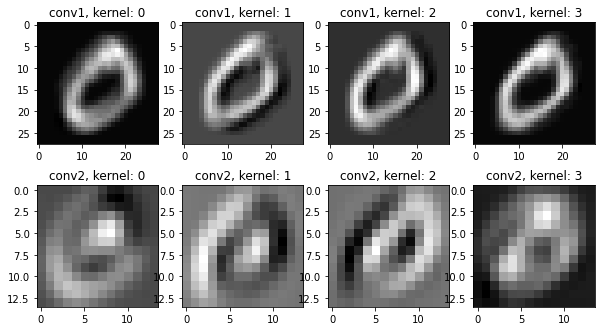

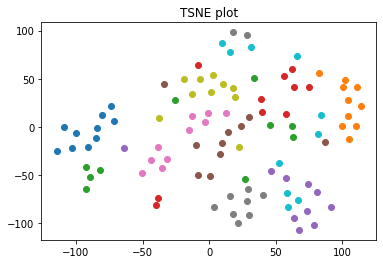

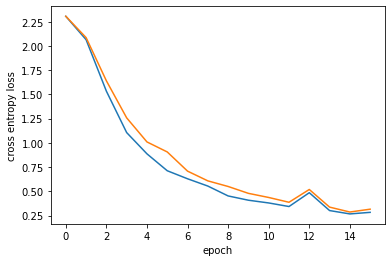

In [12]:
model = CNN()
optim = torch.optim.RMSprop(model.parameters(), lr=0.001, alpha=0.9)

epochs = 15
minibatch = 50

loss = CrossEntropyLoss()
loss_train = [loss(model(dat), labs)]
loss_test = [loss(model(test), test_labs)]

for i in range(epochs):
    print("Currently training on epoch:", i)
    indices = np.random.permutation(dat.shape[0])
    for j in range(dat.shape[0]//minibatch):
        optim.zero_grad()
        preds = model(dat[indices[j*minibatch:(j+1)*minibatch], :, :, :])
        loss_ = loss(preds, labs[indices[j*minibatch:(j+1)*minibatch]])
        loss_.backward()
        optim.step()

    preds__ = model(dat)
    loss_train.append(loss(preds__, labs))
    print("Train accuracy =", accuracy(labs, preds__))
    preds__ = model(test)
    loss_test.append(loss(preds__, test_labs))
    print("Test accuracy =", accuracy(test_labs, preds__))

    figure, ax = plt.subplots(2, 4, figsize=(10,5.5))
    for e in range(4):
        ax[0, e].imshow(np.transpose(model.activ(dat[:1, :, :, :])[0], (1,2,0))[:, :, e], cmap='gray')
        ax[0, e].set_title("conv1, kernel: "+str(e))
    for e in range(4):
        ax[1, e].imshow(np.transpose(model.activ(dat[:1, :, :, :])[1], (1,2,0))[:, :, e], cmap='gray')
        ax[1, e].set_title("conv2, kernel: "+str(e))
    plt.show()

    if i == 0 or i == epochs-1:
        a = TSNE(n_components=2, init='random', perplexity=20, n_iter=5000).fit_transform(model.bottleneck(test))
        for o in range(10):
            plt.scatter(a[10*o:10*o+10, 0], a[10*o:10*o+10, 1], marker='o')
        plt.title("TSNE plot")
        plt.show()

plt.plot(np.arange(epochs+1), loss_train)
plt.plot(np.arange(epochs+1), loss_test)
plt.xlabel("epoch")
plt.ylabel("cross entropy loss")
plt.show()

# Question 5
There is not a very huge difference in the results from assignments 4 and 5. In assignment 4, the loss seemed to converge for all experiments except for SGD with mini-batch size 50. In assignment 5, however, the loss seemed to converge only for both instances of RMSprop and SGD with momentum for batch size 5. However, the key difference is found in execution time. In assignment 4, it took around 30 minutes to train one model as opposed to about 30 seconds in assignment 5. Also, the activations maps in assignment 4 seemed to have less pixel values as positive in contrast to assignment 5.

The highest test accuracy I notices during assignment 4 was 99. In assignment 5, that was however 97.

# Question 6
Below we implement the CNN model with dropout and then train it for the given three values of dropout.

In [13]:
class CNN2(nn.Module):
    def __init__(self, p):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, 5, 1, 2, bias=True)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 4, 5, 1, 2, bias=True)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.flatten = Flatten()
        self.linear1 = nn.Linear(196, 49, bias=True)
        self.linear2 = nn.Linear(49, 10, bias=True)
        self.dropout = nn.Dropout(p)

    def forward(self, x):
        x = relu(self.conv1(x))
        x = self.pool1(x)
        x = relu(self.conv2(x))
        x = self.pool2(x)
        x = self.flatten(x)
        x = relu(self.dropout(self.linear1(x)))
        x = self.linear2(x)
        return x

    def activ(self, x):
        return [self.conv1(x).detach().numpy()[0, :, :, :], self.conv2(self.pool1(relu(self.conv1(x)))).detach().numpy()[0, :, :, :]]

    def bottleneck(self, x):
        return self.flatten(self.pool2(relu(self.conv2(self.pool1(relu(self.conv1(x))))))).detach().numpy()

Currently training on epoch: 0
Train accuracy = 0.694
Test accuracy = 0.67


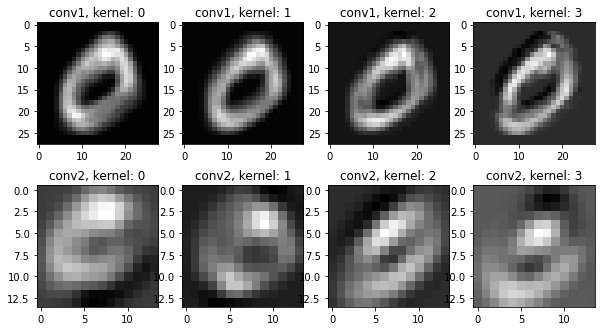

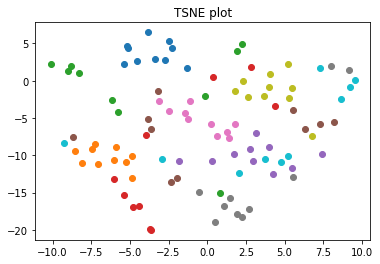

Currently training on epoch: 1
Train accuracy = 0.799
Test accuracy = 0.85


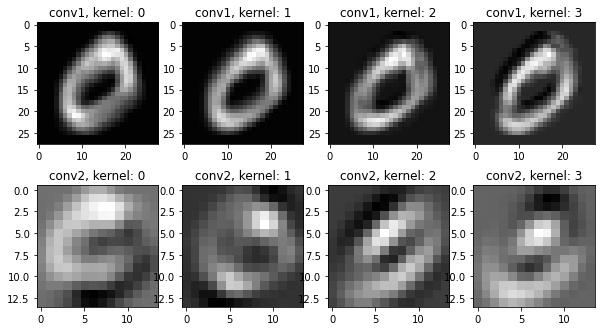

Currently training on epoch: 2
Train accuracy = 0.823
Test accuracy = 0.81


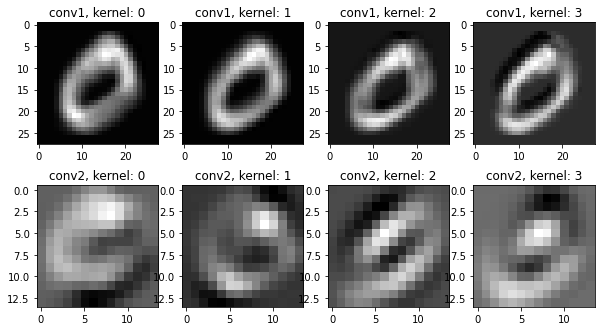

Currently training on epoch: 3
Train accuracy = 0.876
Test accuracy = 0.85


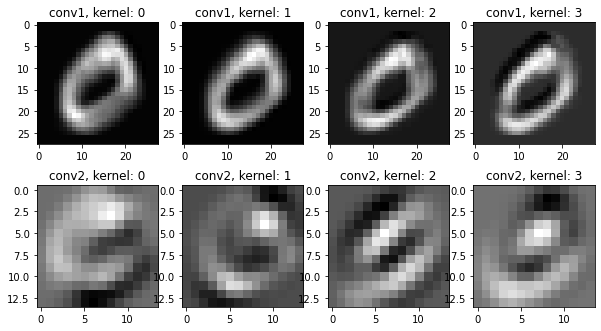

Currently training on epoch: 4
Train accuracy = 0.901
Test accuracy = 0.87


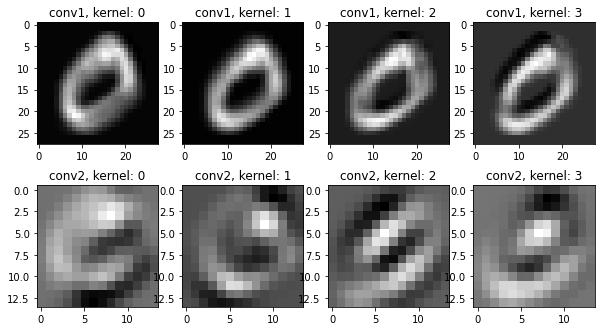

Currently training on epoch: 5
Train accuracy = 0.903
Test accuracy = 0.91


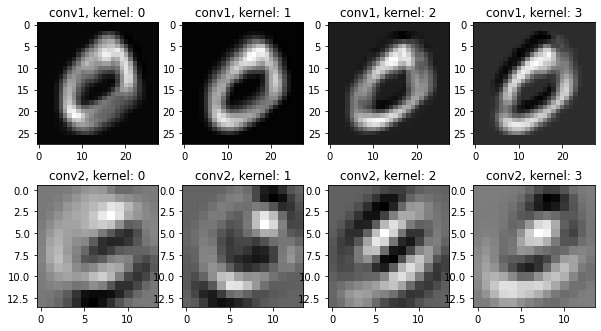

Currently training on epoch: 6
Train accuracy = 0.923
Test accuracy = 0.91


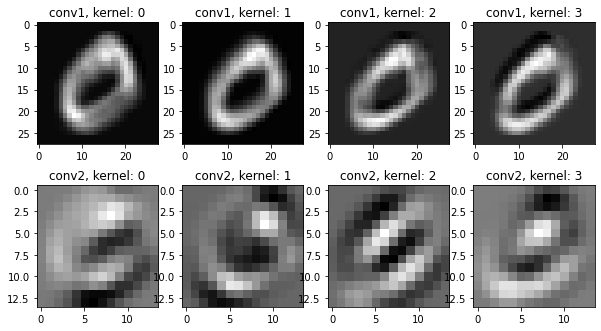

Currently training on epoch: 7
Train accuracy = 0.929
Test accuracy = 0.91


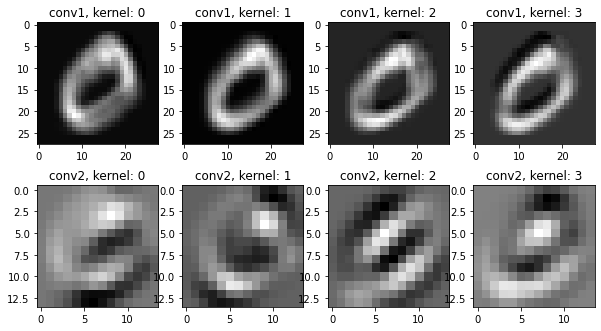

Currently training on epoch: 8
Train accuracy = 0.941
Test accuracy = 0.9


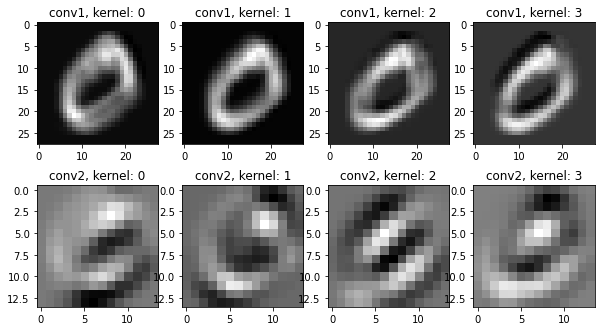

Currently training on epoch: 9
Train accuracy = 0.944
Test accuracy = 0.92


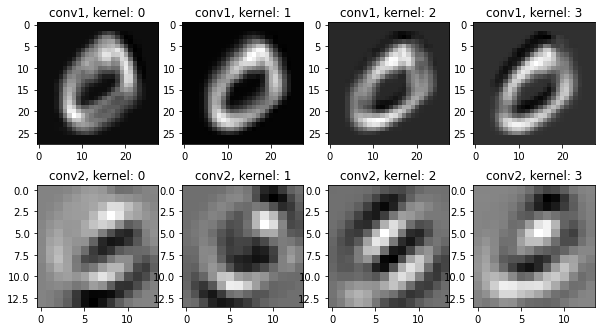

Currently training on epoch: 10
Train accuracy = 0.937
Test accuracy = 0.94


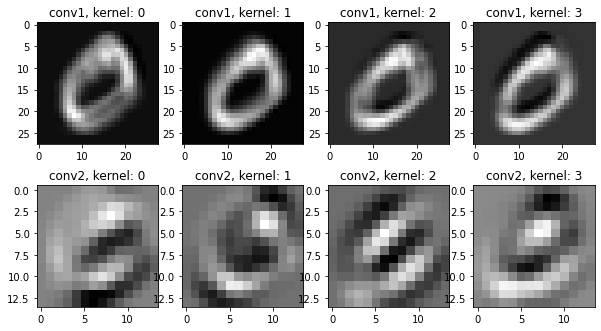

Currently training on epoch: 11
Train accuracy = 0.944
Test accuracy = 0.93


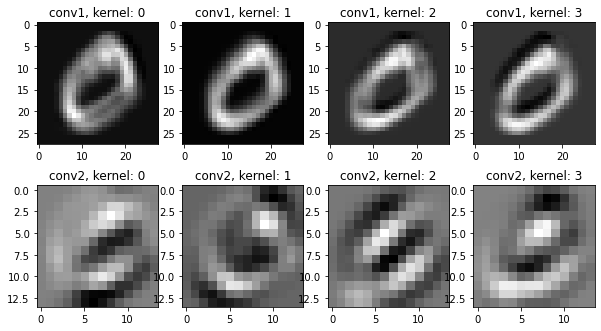

Currently training on epoch: 12
Train accuracy = 0.955
Test accuracy = 0.9


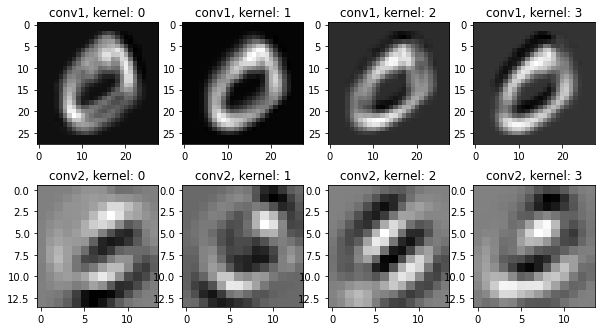

Currently training on epoch: 13
Train accuracy = 0.95
Test accuracy = 0.97


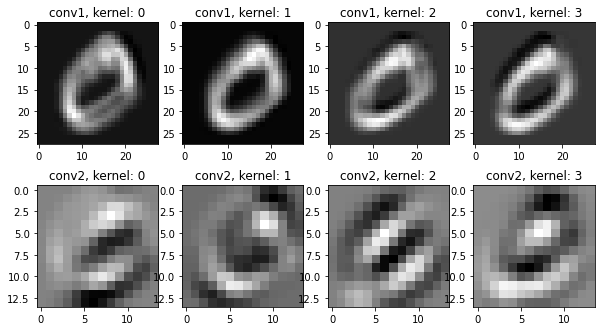

Currently training on epoch: 14
Train accuracy = 0.962
Test accuracy = 0.97


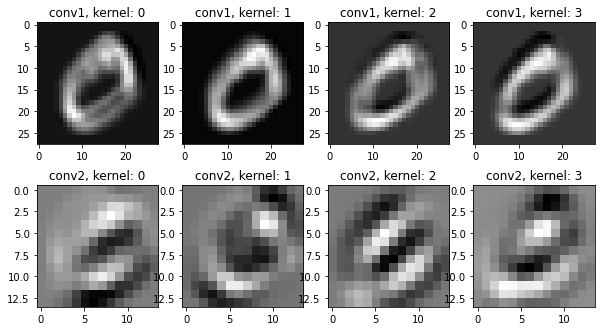

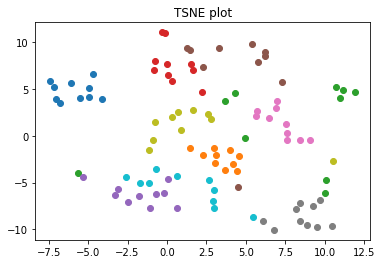

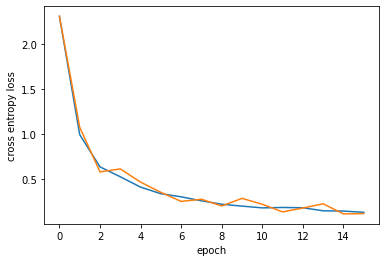

In [14]:
model = CNN2(p=0.2)
optim = torch.optim.RMSprop(model.parameters(), lr=0.001, alpha=0.9)

epochs = 15
minibatch = 5

loss = CrossEntropyLoss()
loss_train = [loss(model(dat), labs)]
loss_test = [loss(model(test), test_labs)]

for i in range(epochs):
    print("Currently training on epoch:", i)
    indices = np.random.permutation(dat.shape[0])
    for j in range(dat.shape[0]//minibatch):
        optim.zero_grad()
        preds = model(dat[indices[j*minibatch:(j+1)*minibatch], :, :, :])
        loss_ = loss(preds, labs[indices[j*minibatch:(j+1)*minibatch]])
        loss_.backward()
        optim.step()

    preds__ = model(dat)
    loss_train.append(loss(preds__, labs))
    print("Train accuracy =", accuracy(labs, preds__))
    preds__ = model(test)
    loss_test.append(loss(preds__, test_labs))
    print("Test accuracy =", accuracy(test_labs, preds__))

    figure, ax = plt.subplots(2, 4, figsize=(10,5.5))
    for e in range(4):
        ax[0, e].imshow(np.transpose(model.activ(dat[:1, :, :, :])[0], (1,2,0))[:, :, e], cmap='gray')
        ax[0, e].set_title("conv1, kernel: "+str(e))
    for e in range(4):
        ax[1, e].imshow(np.transpose(model.activ(dat[:1, :, :, :])[1], (1,2,0))[:, :, e], cmap='gray')
        ax[1, e].set_title("conv2, kernel: "+str(e))
    plt.show()

    if i == 0 or i == epochs-1:
        a = TSNE(n_components=2, init='random', perplexity=20, n_iter=5000).fit_transform(model.bottleneck(test))
        for o in range(10):
            plt.scatter(a[10*o:10*o+10, 0], a[10*o:10*o+10, 1], marker='o')
        plt.title("TSNE plot")
        plt.show()

plt.plot(np.arange(epochs+1), loss_train)
plt.plot(np.arange(epochs+1), loss_test)
plt.xlabel("epoch")
plt.ylabel("cross entropy loss")
plt.show()

Currently training on epoch: 0
Train accuracy = 0.469
Test accuracy = 0.43


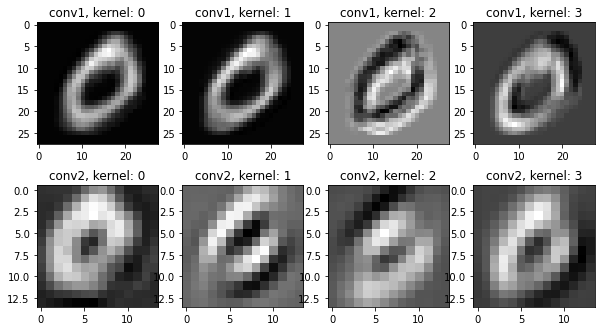

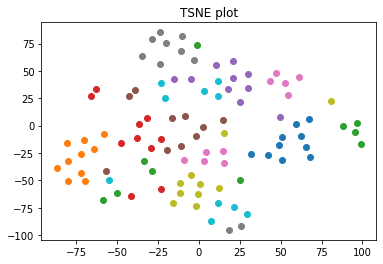

Currently training on epoch: 1
Train accuracy = 0.631
Test accuracy = 0.6


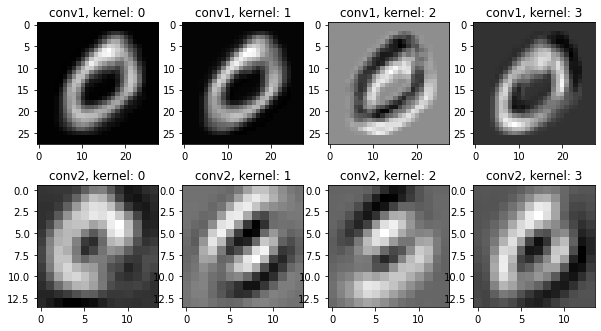

Currently training on epoch: 2
Train accuracy = 0.653
Test accuracy = 0.66


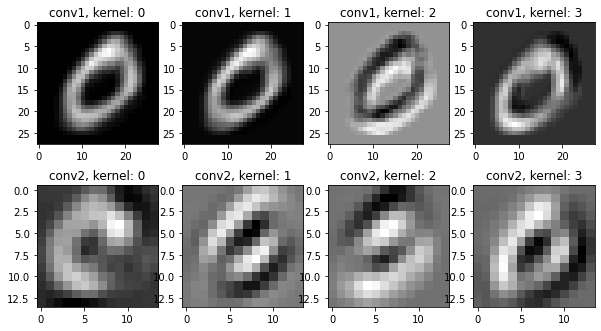

Currently training on epoch: 3
Train accuracy = 0.752
Test accuracy = 0.72


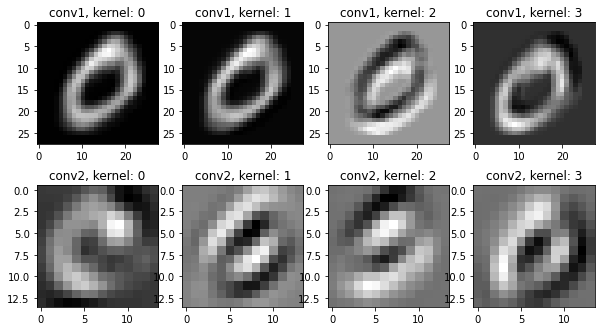

Currently training on epoch: 4
Train accuracy = 0.789
Test accuracy = 0.73


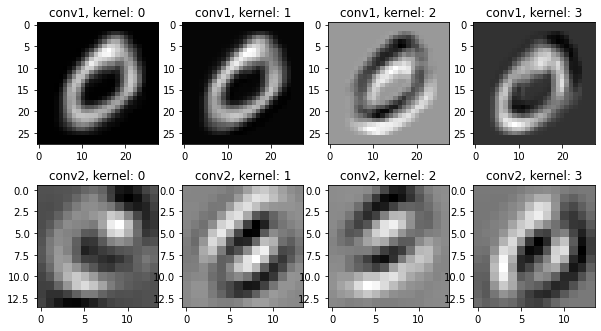

Currently training on epoch: 5
Train accuracy = 0.789
Test accuracy = 0.77


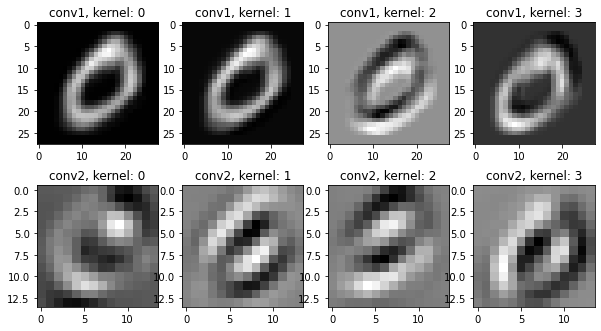

Currently training on epoch: 6
Train accuracy = 0.843
Test accuracy = 0.78


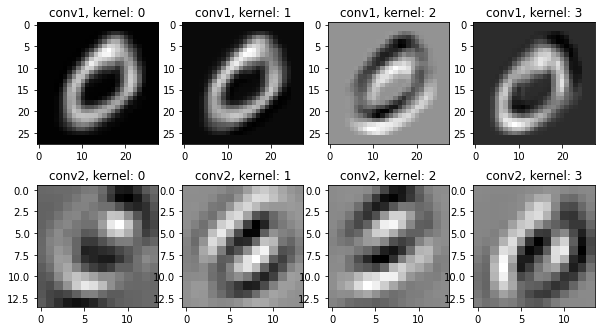

Currently training on epoch: 7
Train accuracy = 0.86
Test accuracy = 0.84


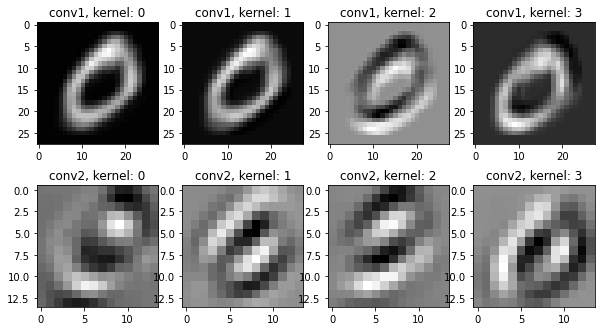

Currently training on epoch: 8
Train accuracy = 0.872
Test accuracy = 0.88


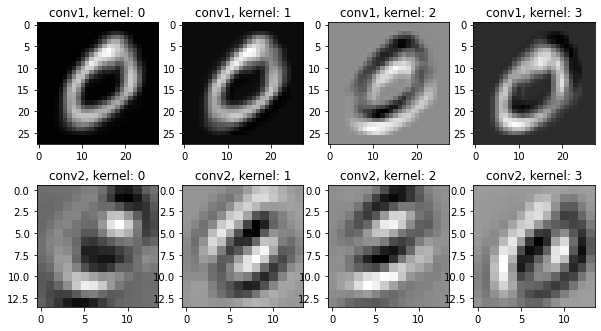

Currently training on epoch: 9
Train accuracy = 0.901
Test accuracy = 0.89


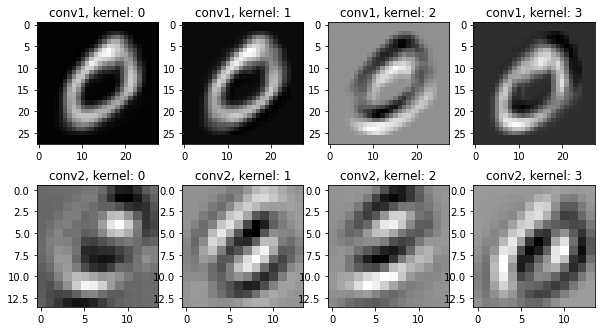

Currently training on epoch: 10
Train accuracy = 0.883
Test accuracy = 0.91


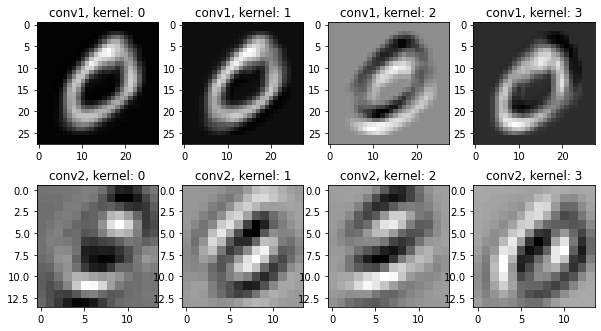

Currently training on epoch: 11
Train accuracy = 0.882
Test accuracy = 0.92


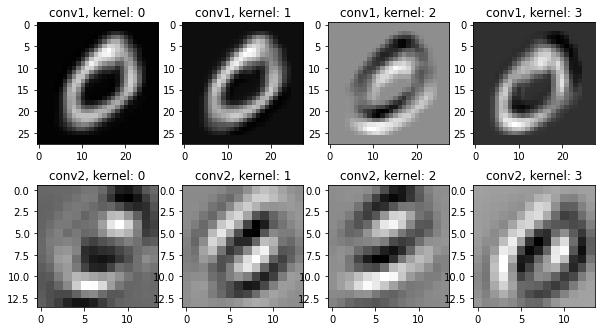

Currently training on epoch: 12
Train accuracy = 0.898
Test accuracy = 0.9


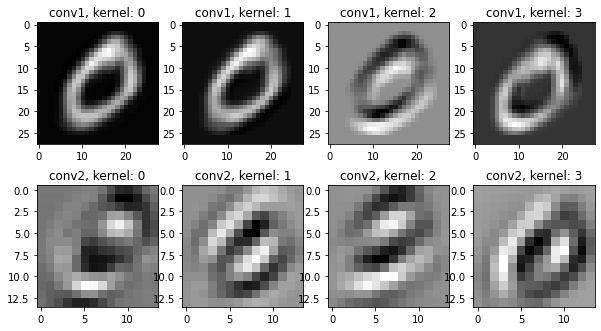

Currently training on epoch: 13
Train accuracy = 0.912
Test accuracy = 0.94


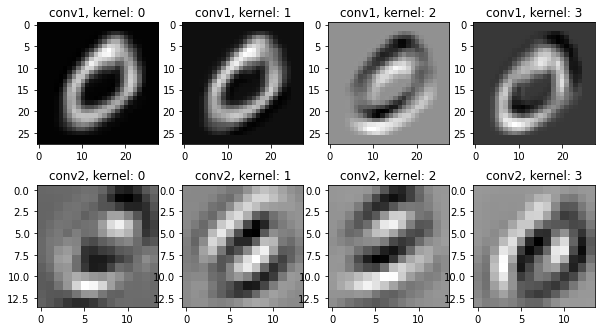

Currently training on epoch: 14
Train accuracy = 0.921
Test accuracy = 0.89


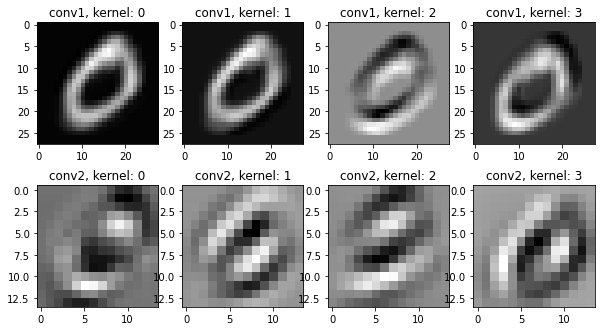

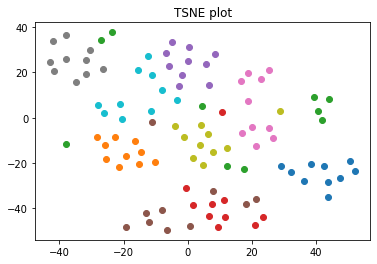

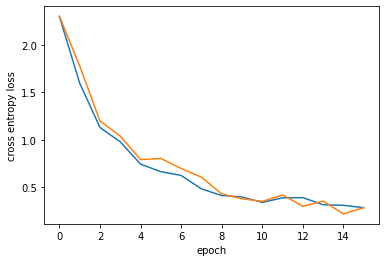

In [15]:
model = CNN2(p=0.5)
optim = torch.optim.RMSprop(model.parameters(), lr=0.001, alpha=0.9)

epochs = 15
minibatch = 5

loss = CrossEntropyLoss()
loss_train = [loss(model(dat), labs)]
loss_test = [loss(model(test), test_labs)]

for i in range(epochs):
    print("Currently training on epoch:", i)
    indices = np.random.permutation(dat.shape[0])
    for j in range(dat.shape[0]//minibatch):
        optim.zero_grad()
        preds = model(dat[indices[j*minibatch:(j+1)*minibatch], :, :, :])
        loss_ = loss(preds, labs[indices[j*minibatch:(j+1)*minibatch]])
        loss_.backward()
        optim.step()

    preds__ = model(dat)
    loss_train.append(loss(preds__, labs))
    print("Train accuracy =", accuracy(labs, preds__))
    preds__ = model(test)
    loss_test.append(loss(preds__, test_labs))
    print("Test accuracy =", accuracy(test_labs, preds__))

    figure, ax = plt.subplots(2, 4, figsize=(10,5.5))
    for e in range(4):
        ax[0, e].imshow(np.transpose(model.activ(dat[:1, :, :, :])[0], (1,2,0))[:, :, e], cmap='gray')
        ax[0, e].set_title("conv1, kernel: "+str(e))
    for e in range(4):
        ax[1, e].imshow(np.transpose(model.activ(dat[:1, :, :, :])[1], (1,2,0))[:, :, e], cmap='gray')
        ax[1, e].set_title("conv2, kernel: "+str(e))
    plt.show()

    if i == 0 or i == epochs-1:
        a = TSNE(n_components=2, init='random', perplexity=20, n_iter=5000).fit_transform(model.bottleneck(test))
        for o in range(10):
            plt.scatter(a[10*o:10*o+10, 0], a[10*o:10*o+10, 1], marker='o')
        plt.title("TSNE plot")
        plt.show()

plt.plot(np.arange(epochs+1), loss_train)
plt.plot(np.arange(epochs+1), loss_test)
plt.xlabel("epoch")
plt.ylabel("cross entropy loss")
plt.show()

Currently training on epoch: 0
Train accuracy = 0.227
Test accuracy = 0.17


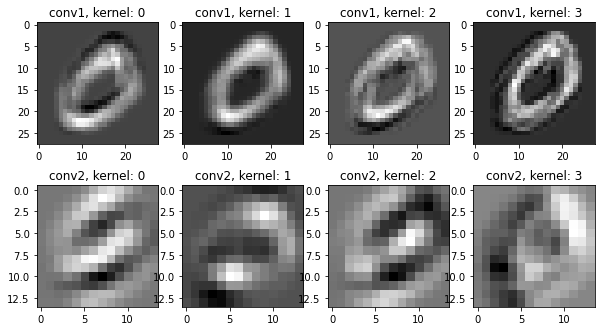

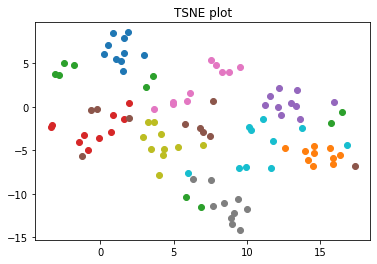

Currently training on epoch: 1
Train accuracy = 0.355
Test accuracy = 0.29


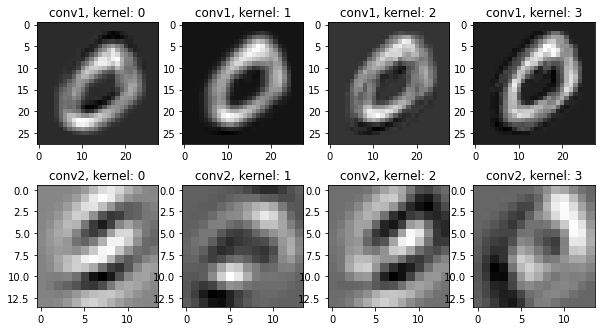

Currently training on epoch: 2
Train accuracy = 0.416
Test accuracy = 0.44


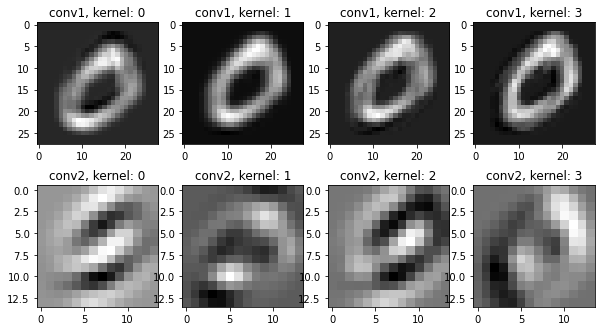

Currently training on epoch: 3
Train accuracy = 0.445
Test accuracy = 0.48


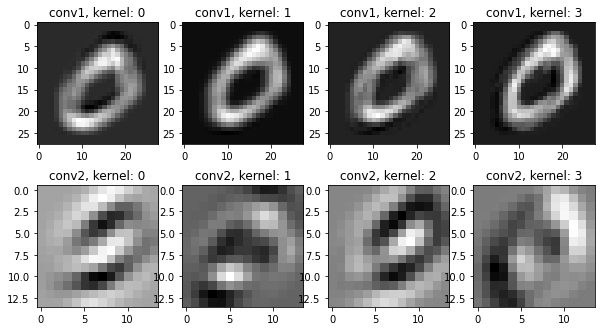

Currently training on epoch: 4
Train accuracy = 0.465
Test accuracy = 0.49


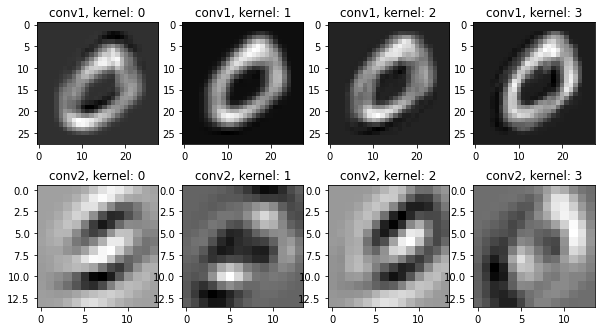

Currently training on epoch: 5
Train accuracy = 0.492
Test accuracy = 0.53


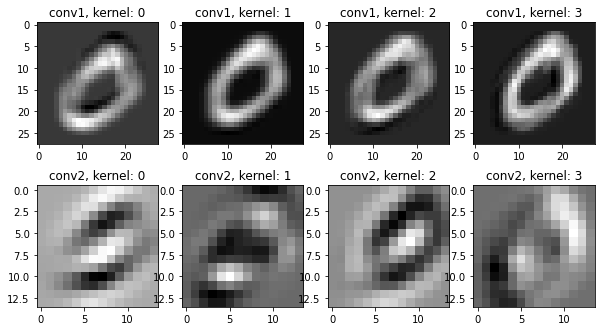

Currently training on epoch: 6
Train accuracy = 0.523
Test accuracy = 0.49


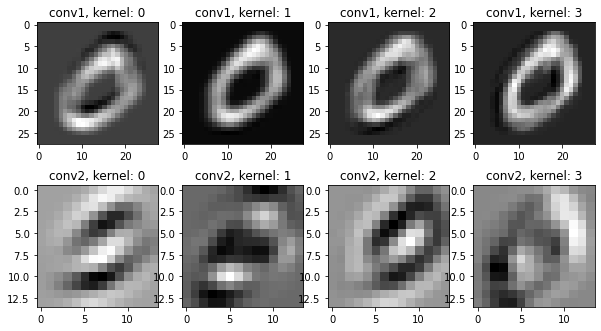

Currently training on epoch: 7
Train accuracy = 0.54
Test accuracy = 0.54


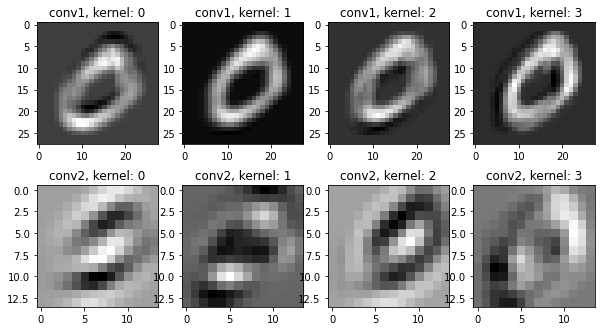

Currently training on epoch: 8
Train accuracy = 0.568
Test accuracy = 0.43


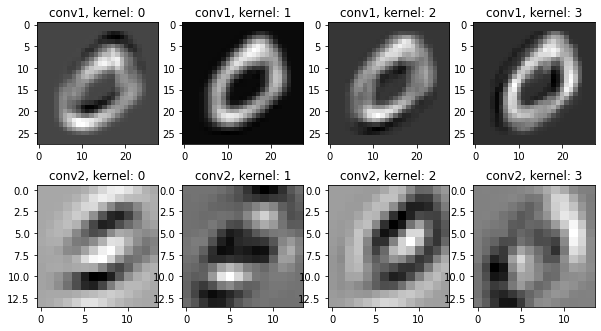

Currently training on epoch: 9
Train accuracy = 0.547
Test accuracy = 0.5


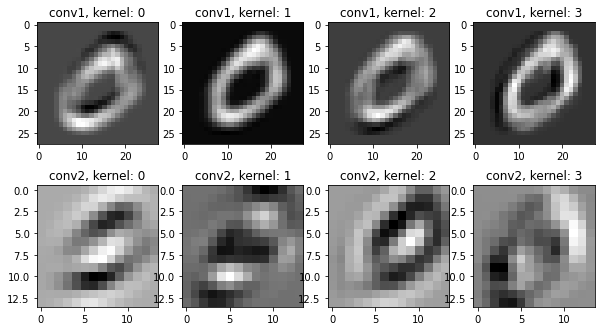

Currently training on epoch: 10
Train accuracy = 0.577
Test accuracy = 0.6


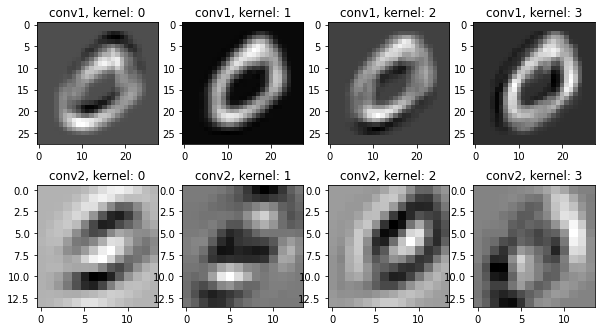

Currently training on epoch: 11
Train accuracy = 0.568
Test accuracy = 0.56


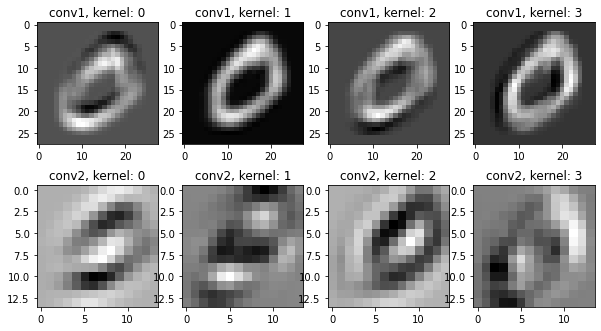

Currently training on epoch: 12
Train accuracy = 0.575
Test accuracy = 0.64


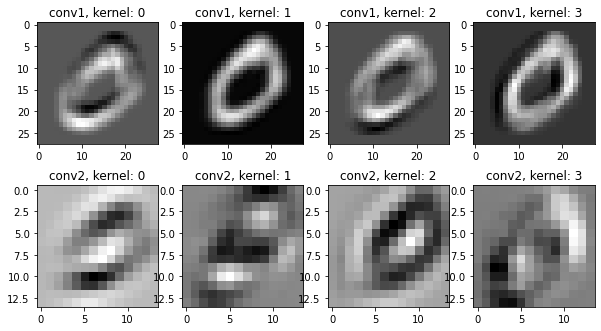

Currently training on epoch: 13
Train accuracy = 0.594
Test accuracy = 0.58


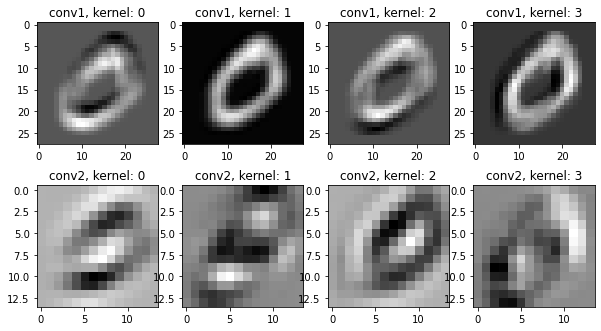

Currently training on epoch: 14
Train accuracy = 0.591
Test accuracy = 0.51


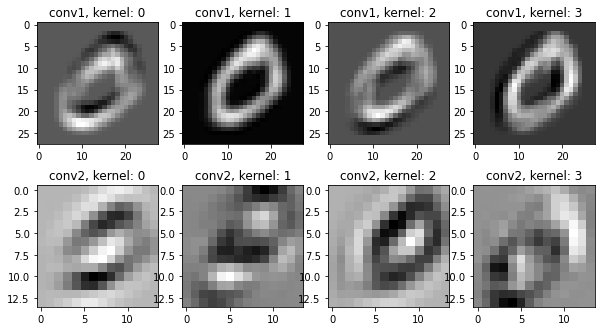

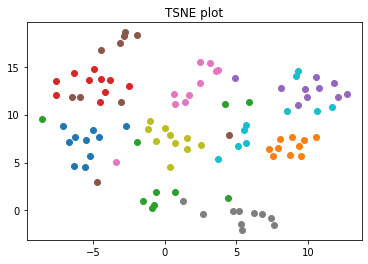

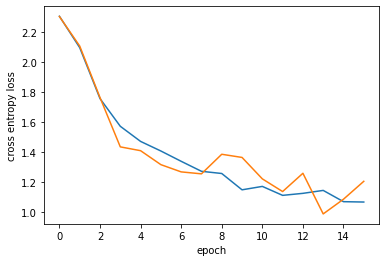

In [16]:
model = CNN2(p=0.8)
optim = torch.optim.RMSprop(model.parameters(), lr=0.001, alpha=0.9)

epochs = 15
minibatch = 5

loss = CrossEntropyLoss()
loss_train = [loss(model(dat), labs)]
loss_test = [loss(model(test), test_labs)]

for i in range(epochs):
    print("Currently training on epoch:", i)
    indices = np.random.permutation(dat.shape[0])
    for j in range(dat.shape[0]//minibatch):
        optim.zero_grad()
        preds = model(dat[indices[j*minibatch:(j+1)*minibatch], :, :, :])
        loss_ = loss(preds, labs[indices[j*minibatch:(j+1)*minibatch]])
        loss_.backward()
        optim.step()

    preds__ = model(dat)
    loss_train.append(loss(preds__, labs))
    print("Train accuracy =", accuracy(labs, preds__))
    preds__ = model(test)
    loss_test.append(loss(preds__, test_labs))
    print("Test accuracy =", accuracy(test_labs, preds__))

    figure, ax = plt.subplots(2, 4, figsize=(10,5.5))
    for e in range(4):
        ax[0, e].imshow(np.transpose(model.activ(dat[:1, :, :, :])[0], (1,2,0))[:, :, e], cmap='gray')
        ax[0, e].set_title("conv1, kernel: "+str(e))
    for e in range(4):
        ax[1, e].imshow(np.transpose(model.activ(dat[:1, :, :, :])[1], (1,2,0))[:, :, e], cmap='gray')
        ax[1, e].set_title("conv2, kernel: "+str(e))
    plt.show()

    if i == 0 or i == epochs-1:
        a = TSNE(n_components=2, init='random', perplexity=20, n_iter=5000).fit_transform(model.bottleneck(test))
        for o in range(10):
            plt.scatter(a[10*o:10*o+10, 0], a[10*o:10*o+10, 1], marker='o')
        plt.title("TSNE plot")
        plt.show()

plt.plot(np.arange(epochs+1), loss_train)
plt.plot(np.arange(epochs+1), loss_test)
plt.xlabel("epoch")
plt.ylabel("cross entropy loss")
plt.show()

With dropout (0.2), the fluctuation in training accuracy is much less in comparison to before. This probably indicates that we are seeing less over-fitting. However, for dropout values of 0.5 and 0.8, the testing accuracy decreased. For 0.5, there was less fluctuation however, for 0.8, there are more fluctuations. This probably indicates that we are inhibiting learning in the network. The accuracy is also much lower in comparison.

# Question 7
Below we implement the model with batch norm.

In [19]:
class CNN3(nn.Module):
    def __init__(self, p):
        super(CNN3, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, 5, 1, 2, bias=True)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 4, 5, 1, 2, bias=True)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.flatten = Flatten()
        self.linear1 = nn.Linear(196, 49, bias=True)
        self.linear2 = nn.Linear(49, 10, bias=True)
        self.dropout = nn.Dropout(p)
        self.bn = nn.BatchNorm1d(49)

    def forward(self, x):
        x = relu(self.conv1(x))
        x = self.pool1(x)
        x = relu(self.conv2(x))
        x = self.pool2(x)
        x = self.flatten(x)
        x = relu(self.dropout(self.bn(self.linear1(x))))
        x = self.linear2(x)
        return x

    def activ(self, x):
        return [self.conv1(x).detach().numpy()[0, :, :, :], self.conv2(self.pool1(relu(self.conv1(x)))).detach().numpy()[0, :, :, :]]

    def bottleneck(self, x):
        return self.flatten(self.pool2(relu(self.conv2(self.pool1(relu(self.conv1(x))))))).detach().numpy()

Currently training on epoch: 0
Train accuracy = 0.828
Test accuracy = 0.72


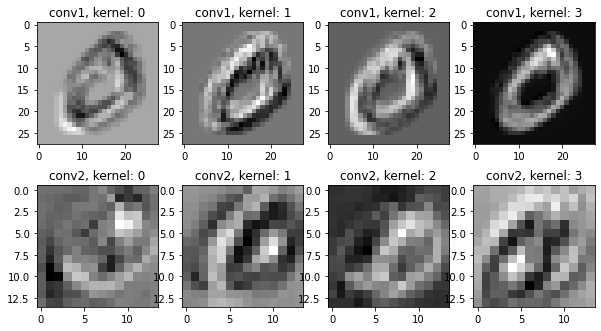

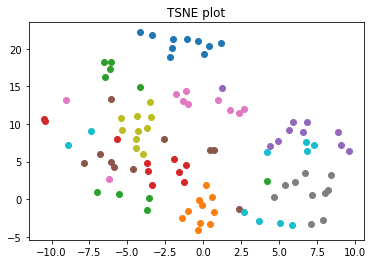

Currently training on epoch: 1
Train accuracy = 0.91
Test accuracy = 0.86


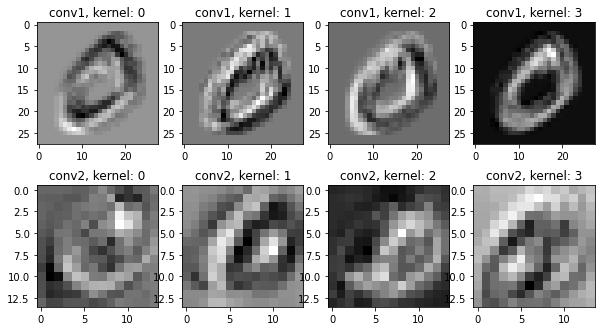

Currently training on epoch: 2
Train accuracy = 0.936
Test accuracy = 0.91


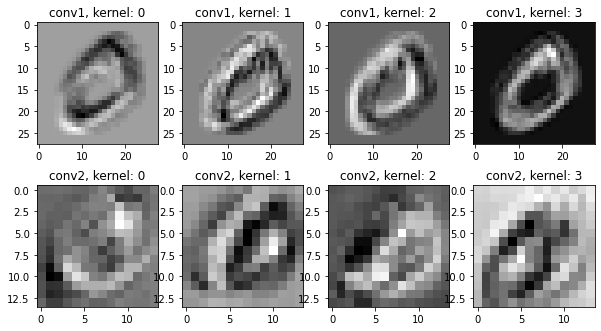

Currently training on epoch: 3
Train accuracy = 0.955
Test accuracy = 0.98


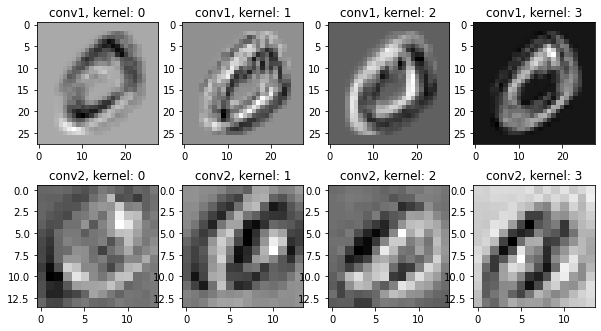

Currently training on epoch: 4
Train accuracy = 0.958
Test accuracy = 0.94


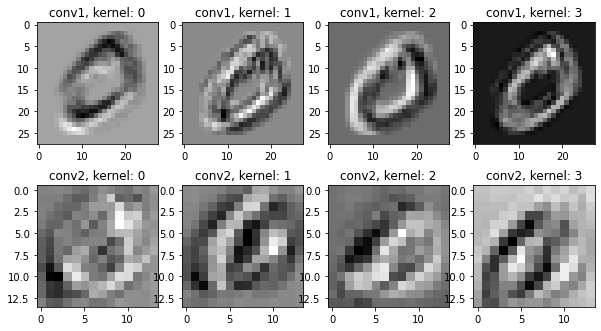

Currently training on epoch: 5
Train accuracy = 0.971
Test accuracy = 0.95


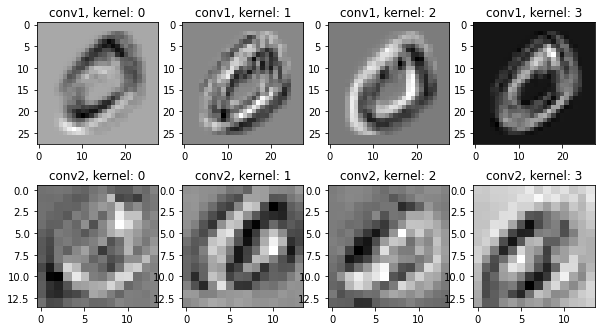

Currently training on epoch: 6
Train accuracy = 0.968
Test accuracy = 0.94


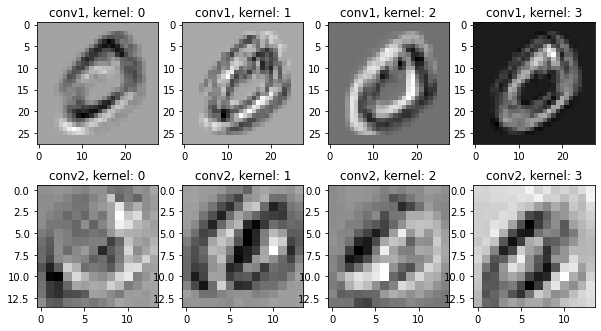

Currently training on epoch: 7
Train accuracy = 0.976
Test accuracy = 0.95


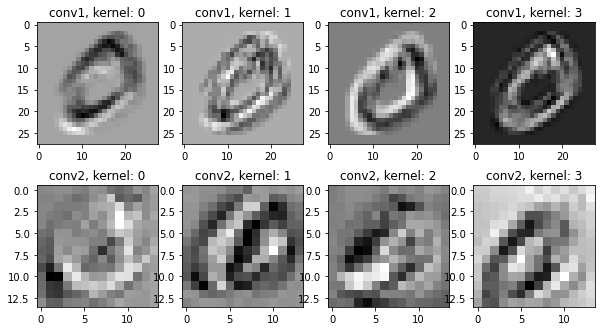

Currently training on epoch: 8
Train accuracy = 0.98
Test accuracy = 0.94


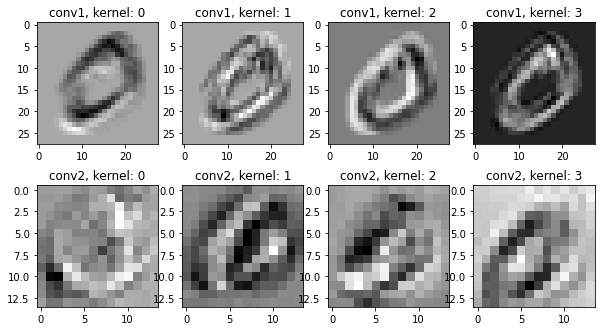

Currently training on epoch: 9
Train accuracy = 0.979
Test accuracy = 0.96


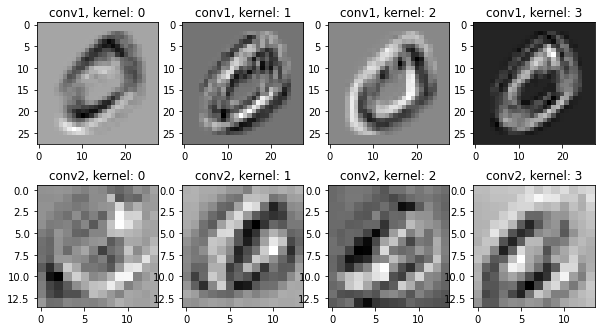

Currently training on epoch: 10
Train accuracy = 0.984
Test accuracy = 0.99


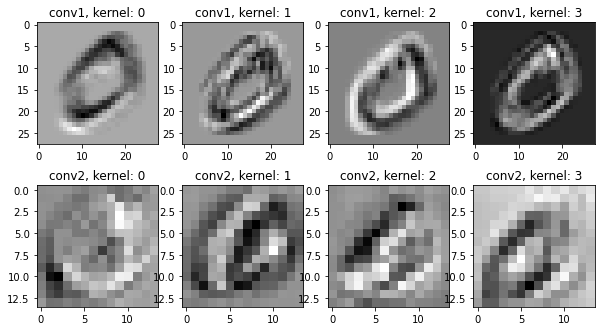

Currently training on epoch: 11
Train accuracy = 0.986
Test accuracy = 0.99


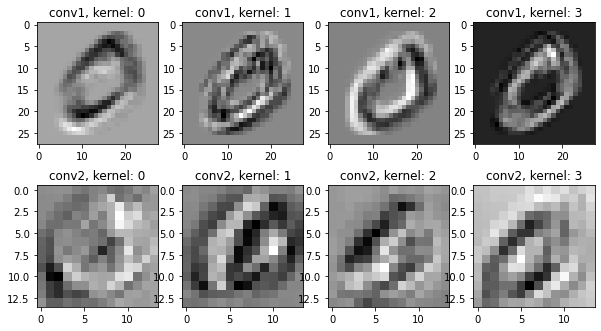

Currently training on epoch: 12
Train accuracy = 0.986
Test accuracy = 0.96


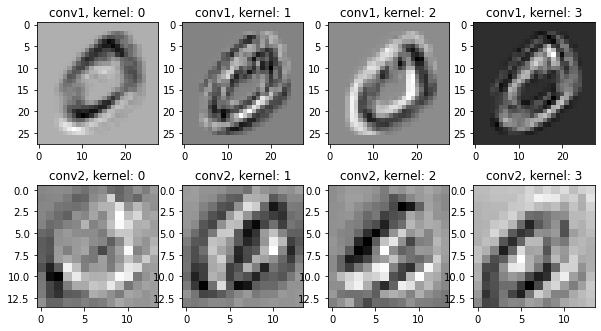

Currently training on epoch: 13
Train accuracy = 0.99
Test accuracy = 0.96


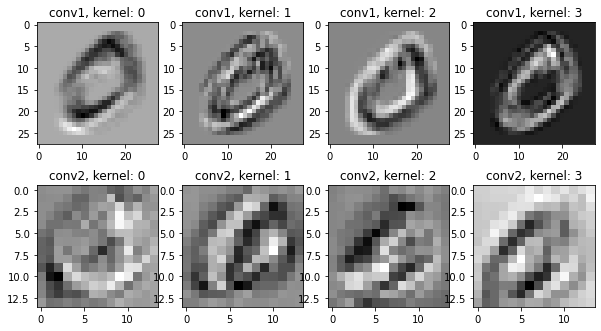

Currently training on epoch: 14
Train accuracy = 0.989
Test accuracy = 0.95


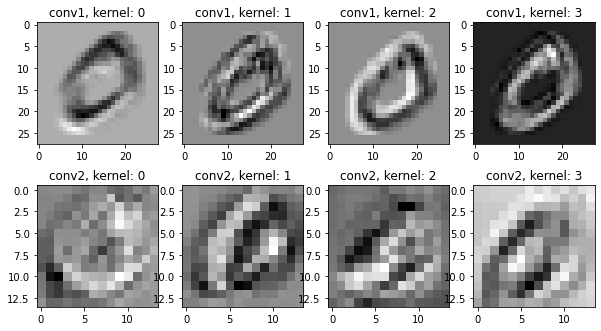

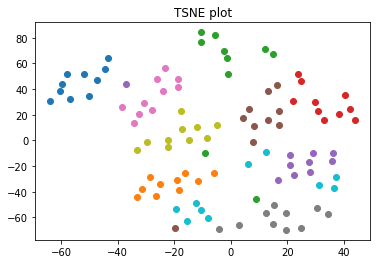

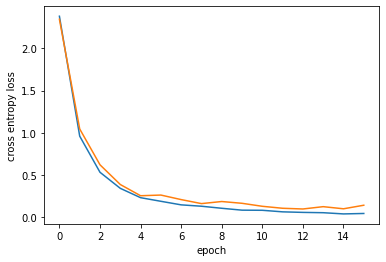

In [20]:
model = CNN3(p=0.2)
optim = torch.optim.RMSprop(model.parameters(), lr=0.001, alpha=0.9)

epochs = 15
minibatch = 5

loss = CrossEntropyLoss()
loss_train = [loss(model(dat), labs)]
loss_test = [loss(model(test), test_labs)]

for i in range(epochs):
    print("Currently training on epoch:", i)
    indices = np.random.permutation(dat.shape[0])
    for j in range(dat.shape[0]//minibatch):
        optim.zero_grad()
        preds = model(dat[indices[j*minibatch:(j+1)*minibatch], :, :, :])
        loss_ = loss(preds, labs[indices[j*minibatch:(j+1)*minibatch]])
        loss_.backward()
        optim.step()

    preds__ = model(dat)
    loss_train.append(loss(preds__, labs))
    print("Train accuracy =", accuracy(labs, preds__))
    preds__ = model(test)
    loss_test.append(loss(preds__, test_labs))
    print("Test accuracy =", accuracy(test_labs, preds__))

    figure, ax = plt.subplots(2, 4, figsize=(10,5.5))
    for e in range(4):
        ax[0, e].imshow(np.transpose(model.activ(dat[:1, :, :, :])[0], (1,2,0))[:, :, e], cmap='gray')
        ax[0, e].set_title("conv1, kernel: "+str(e))
    for e in range(4):
        ax[1, e].imshow(np.transpose(model.activ(dat[:1, :, :, :])[1], (1,2,0))[:, :, e], cmap='gray')
        ax[1, e].set_title("conv2, kernel: "+str(e))
    plt.show()

    if i == 0 or i == epochs-1:
        a = TSNE(n_components=2, init='random', perplexity=20, n_iter=5000).fit_transform(model.bottleneck(test))
        for o in range(10):
            plt.scatter(a[10*o:10*o+10, 0], a[10*o:10*o+10, 1], marker='o')
        plt.title("TSNE plot")
        plt.show()

plt.plot(np.arange(epochs+1), loss_train)
plt.plot(np.arange(epochs+1), loss_test)
plt.xlabel("epoch")
plt.ylabel("cross entropy loss")
plt.show()

With Batch norm, the loss converged much faster. There are no fluctuations in training accuracy, indicating less over-fitting. The testing accuracy finally reached 99 which compares well against that achieved in assignment 4. The accuracy is clearly higher than earlier, where we were not using Batch norm and only using dropout.

Batch Norm was performed before dropout.